<a href="https://colab.research.google.com/github/MieuLam/Advance_AI_Final_Lab/blob/main/Advance_AI_Final_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install gdown
#!gdown --no-check-certificate --folder https://drive.google.com/drive/folders/1GdUXuy6ncUD36SvbeiS1hTEF7CKjghYA?usp=sharing --remaining-ok

In [ ]:
!pip install tensorflow-addons

In [ ]:
!pip install wfdb

In [ ]:
!pip install ecg-plot
#import physionet_challenge_utility_script as pc
from scipy.signal import find_peaks
import os
import seaborn as sns
import pandas as pd
from scipy.signal import peak_widths
from sklearn import preprocessing
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from keras.utils import plot_model
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Add
from keras import layers
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import math
from sklearn.preprocessing import MultiLabelBinarizer
from scipy import optimize
import wfdb
from sklearn.preprocessing import LabelEncoder
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPool1D, ZeroPadding1D, LSTM, Bidirectional
from keras.layers import concatenate
import numpy as np
from scipy.io import loadmat
from scipy.signal import savgol_filter
from sklearn.model_selection import StratifiedKFold
import ecg_plot
from keras.models import Sequential, Model
import numpy as np, sys,os
import tarfile
#from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from scipy.signal import butter, lfilter, filtfilt
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

%load_ext autoreload
%autoreload
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#Create Utility

In [ ]:
def load_challenge_data(filename):
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data

def clean_up_gender_data(gender):
  gender = np.asarray(gender)
  gender[np.where(gender == "Male")] = 0
  gender[np.where(gender == "male")] = 0
  gender[np.where(gender == "M")] = 0
  gender[np.where(gender == "Female")] = 1
  gender[np.where(gender == "female")] = 1
  gender[np.where(gender == "F")] = 1
  gender[np.where(gender == "NaN")] = 2
  np.unique(gender)
  gender = gender.astype(np.int)
  return gender

def clean_up_age_data(age):
    age = np.asarray(age)
    age[np.where(age == "NaN")] = -1
    np.unique(age)
    age = age.astype(np.int)
    return age

def import_gender_and_age(age, gender):
    gender_binary = clean_up_gender_data(gender)
    age_clean = clean_up_age_data(age)
    print("gender data shape: {}".format(gender_binary.shape[0]))
    print("age data shape: {}".format(age_clean.shape[0]))
    return age_clean, gender_binary

def import_key_data(path):
    gender=[]
    age=[]
    labels=[]
    ecg_filenames=[]
    for subdir, dirs, files in sorted(os.walk(path)):
        for filename in files:
            filepath = subdir + os.sep + filename
            if filepath.endswith(".mat"):
                data, header_data = load_challenge_data(filepath)
                labels.append(header_data[15][5:-1])
                ecg_filenames.append(filepath)
                gender.append(header_data[14][6:-1])
                age.append(header_data[13][6:-1])
    return gender, age, labels, ecg_filenames

def get_signal_lengths(path, title):
    signal_lenght=[]
    for subdir, dirs, files in sorted(os.walk(path)):
        for filename in files:
            filepath = subdir + os.sep + filename
            if filepath.endswith(".mat"):
                data, header_data = load_challenge_data(filepath)
                splitted = header_data[0].split()
                signal_lenght.append(splitted[3])
    signal_lenght_df = pd.DataFrame(signal_lenght)
    signal_count=signal_lenght_df[0].value_counts()
    plt.figure(figsize=(20,10))
    plt.title(title,fontsize =36)
    sns.barplot(signal_count[:10,].index, signal_count[:10,].values)
      #plt.savefig("signallengde.png")

def make_undefined_class(labels, df_unscored):
    df_labels = pd.DataFrame(labels)
    for i in range(len(df_unscored.iloc[0:,1])):
        df_labels.replace(to_replace=str(df_unscored.iloc[i,1]), inplace=True ,value="undefined class", regex=True)

    '''
    #equivalent classes
    codes_to_replace=['713427006','284470004','427172004']
    replace_with = ['59118001','63593006','17338001']

    for i in range(len(codes_to_replace)):
        df_labels.replace(to_replace=codes_to_replace[i], inplace=True ,value=replace_with[i], regex=True)
    '''
    return df_labels


def onehot_encode(df_labels):
    one_hot = MultiLabelBinarizer()
    y=one_hot.fit_transform(df_labels[0].str.split(pat=','))
    print("The classes we will look at are encoded as SNOMED CT codes:")
    print(one_hot.classes_)
    y = np.delete(y, -1, axis=1)
    print("classes: {}".format(y.shape[1]))
    return y, one_hot.classes_[0:-1]


def plot_classes(classes, scored_classes,y):
    for j in range(len(classes)):
        for i in range(len(scored_classes.iloc[:,1])):
            if (str(scored_classes.iloc[:,1][i]) == classes[j]):
                classes[j] = scored_classes.iloc[:,0][i]
    plt.figure(figsize=(30,20))
    plt.bar(x=classes,height=y.sum(axis=0))
    plt.title("Distribution of Diagnosis", color = "black", fontsize = 30)
    plt.tick_params(axis="both", colors = "black")
    plt.xlabel("Diagnosis", color = "black")
    plt.ylabel("Count", color = "black")
    plt.xticks(rotation=90, fontsize=20)
    plt.yticks(fontsize = 20)
    plt.savefig("fordeling.png")
    plt.show()


def get_labels_for_all_combinations(y):
    y_all_combinations = LabelEncoder().fit_transform([''.join(str(l)) for l in y])
    return y_all_combinations

def split_data(labels, y_all_combo):
    folds = list(StratifiedKFold(n_splits=10, shuffle=True, random_state=42).split(labels,y_all_combo))
    print("Training split: {}".format(len(folds[0][0])))
    print("Validation split: {}".format(len(folds[0][1])))
    return folds

def split_data_test(labels, y_all_combo):
    folds = list(StratifiedKFold(n_splits=2, shuffle=True, random_state=42).split(labels,y_all_combo))
    print("Training split: {}".format(len(folds[0][0])))
    print("Validation split: {}".format(len(folds[0][1])))
    return folds


def plot_all_folds(folds,y,onehot_enc):
    X_axis_labels=onehot_enc
    plt.figure(figsize=(20,100))
    h=1
    for i in range(len(folds)):
        plt.subplot(10,2,h)
        plt.subplots_adjust(hspace=1.0)
        plt.bar(x= X_axis_labels, height=y[folds[i][0]].sum(axis=0))
        plt.title("Distribution of Diagnosis - Training set - Fold {}".format(i+1) ,fontsize="20", color = "black")
        plt.tick_params(axis="both", colors = "black")
        plt.xticks(rotation=90, fontsize=10)
        plt.yticks(fontsize = 10)
        #plt.xlabel("Diagnosis", color = "white")
        plt.ylabel("Count", color = "black")
        h=h+1
        plt.subplot(10,2,h)
        plt.subplots_adjust(hspace=1.0)
        plt.bar(x= X_axis_labels, height=y[folds[i][1]].sum(axis=0))
        plt.title("Distribution of Diagnosis - Validation set - Fold {}".format(i+1) ,fontsize="20", color = "black")
        plt.tick_params(axis="both", colors = "black")
        #plt.xlabel("Diagnosis", color = "white")
        plt.ylabel("Count", color = "black")
        plt.xticks(rotation=90, fontsize=10)
        plt.yticks(fontsize = 10)
        h=h+1

def get_val_data(validation_filename):
    ecg_val_timeseries=[]
    for names in validation_filename:
        data, header_data = load_challenge_data(names)
        data = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
        ecg_val_timeseries.append(data)
    ecg_val_timeseries = np.asarray(ecg_val_timeseries)
    return ecg_val_timeseries

def generate_validation_data(ecg_filenames, y,test_order_array):
    y_train_gridsearch=y[test_order_array]
    ecg_filenames_train_gridsearch=ecg_filenames[test_order_array]

    ecg_train_timeseries=[]
    for names in ecg_filenames_train_gridsearch:
        data, header_data = load_challenge_data(names)
        data = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
        ecg_train_timeseries.append(data)
    X_train_gridsearch = np.asarray(ecg_train_timeseries)

    X_train_gridsearch = X_train_gridsearch.reshape(ecg_filenames_train_gridsearch.shape[0],5000,12)

    return X_train_gridsearch, y_train_gridsearch

def generate_validation_data_with_demo_data(ecg_filenames, y, gender, age, test_order_array):
    y_train_gridsearch=y[test_order_array]
    ecg_filenames_train_gridsearch=ecg_filenames[test_order_array]

    ecg_train_timeseries=[]
    for names in ecg_filenames_train_gridsearch:
        data, header_data = load_challenge_data(names)
        data = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
        ecg_train_timeseries.append(data)
    X_val = np.asarray(ecg_train_timeseries)

    X_val = X_val.reshape(ecg_filenames_train_gridsearch.shape[0],5000,12)

    age_val = age[test_order_array]

    gender_val = gender[test_order_array]

    demograpics_val_data = np.column_stack((age_val, gender_val))
    X_combined_val = [X_val, demograpics_val_data]

    return X_combined_val, y_train_gridsearch



def calculating_class_weights(y_true):
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight('balanced', [0.,1.], y_true[:, i])
    return weights


def residual_network_1d():
    n_feature_maps = 64
    input_shape = (5000,12)
    input_layer = keras.layers.Input(input_shape)

    # BLOCK 1

    conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_1 = keras.layers.add([shortcut_y, conv_z])
    output_block_1 = keras.layers.Activation('relu')(output_block_1)

    # BLOCK 2

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_2 = keras.layers.add([shortcut_y, conv_z])
    output_block_2 = keras.layers.Activation('relu')(output_block_2)

    # BLOCK 3

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = keras.layers.BatchNormalization()(output_block_2)

    output_block_3 = keras.layers.add([shortcut_y, conv_z])
    output_block_3 = keras.layers.Activation('relu')(output_block_3)

    # FINAL

    gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

    output_layer = keras.layers.Dense(27, activation='softmax')(gap_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'),
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])


    return model

def encoder_model():
    input_layer = keras.layers.Input(shape=(5000, 12))


     # conv block -1
    conv1 = keras.layers.Conv1D(filters=128,kernel_size=5,strides=1,padding='same')(input_layer)
    conv1 = tfa.layers.InstanceNormalization()(conv1)
    conv1 = keras.layers.PReLU(shared_axes=[1])(conv1)
    conv1 = keras.layers.Dropout(rate=0.2)(conv1)
    conv1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)
    # conv block -2
    conv2 = keras.layers.Conv1D(filters=256,kernel_size=11,strides=1,padding='same')(conv1)
    conv2 = tfa.layers.InstanceNormalization()(conv2)
    conv2 = keras.layers.PReLU(shared_axes=[1])(conv2)
    conv2 = keras.layers.Dropout(rate=0.2)(conv2)
    conv2 = keras.layers.MaxPooling1D(pool_size=2)(conv2)
    # conv block -3
    conv3 = keras.layers.Conv1D(filters=512,kernel_size=21,strides=1,padding='same')(conv2)
    conv3 = tfa.layers.InstanceNormalization()(conv3)
    conv3 = keras.layers.PReLU(shared_axes=[1])(conv3)
    conv3 = keras.layers.Dropout(rate=0.2)(conv3)
    # split for attention
    attention_data = keras.layers.Lambda(lambda x: x[:,:,:256])(conv3)
    attention_softmax = keras.layers.Lambda(lambda x: x[:,:,256:])(conv3)
    # attention mechanism
    attention_softmax = keras.layers.Softmax()(attention_softmax)
    multiply_layer = keras.layers.Multiply()([attention_softmax,attention_data])
    # last layer
    dense_layer = keras.layers.Dense(units=256,activation='sigmoid')(multiply_layer)
    dense_layer = tfa.layers.InstanceNormalization()(dense_layer)
    # output layer
    flatten_layer = keras.layers.Flatten()(dense_layer)
    output_layer = keras.layers.Dense(units=27,activation='sigmoid')(flatten_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'),
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

    return model

def FCN():
    inputlayer = keras.layers.Input(shape=(5000,12))

    conv1 = keras.layers.Conv1D(filters=128, kernel_size=8,input_shape=(5000,12), padding='same')(inputlayer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activation='relu')(conv1)

    conv2 = keras.layers.Conv1D(filters=256, kernel_size=5, padding='same')(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation('relu')(conv2)

    conv3 = keras.layers.Conv1D(128, kernel_size=3,padding='same')(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation('relu')(conv3)

    gap_layer = keras.layers.GlobalAveragePooling1D()(conv3)


    outputlayer = keras.layers.Dense(27, activation='sigmoid')(gap_layer)

    model = keras.Model(inputs=inputlayer, outputs=outputlayer)



    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'),
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

    return model

def residual_network_1d_demo():
    n_feature_maps = 64
    input_shape = (5000,12)
    inputA = keras.layers.Input(input_shape)
    inputB = keras.layers.Input(shape=(2,))

    # BLOCK 1

    conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(inputA)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(inputA)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_1 = keras.layers.add([shortcut_y, conv_z])
    output_block_1 = keras.layers.Activation('relu')(output_block_1)

    # BLOCK 2

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_2 = keras.layers.add([shortcut_y, conv_z])
    output_block_2 = keras.layers.Activation('relu')(output_block_2)

    # BLOCK 3

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = keras.layers.BatchNormalization()(output_block_2)

    output_block_3 = keras.layers.add([shortcut_y, conv_z])
    output_block_3 = keras.layers.Activation('relu')(output_block_3)

    # FINAL

    gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

    output_layer = keras.layers.Dense(27, activation='softmax')(gap_layer)

    mod1 = keras.models.Model(inputs=inputA, outputs=output_layer)


    mod2 = keras.layers.Dense(50, activation="relu")(inputB)
    mod2 = keras.layers.Dense(2, activation="sigmoid")(mod2)
    mod2 = keras.models.Model(inputs=inputB, outputs=mod2)

    combined = keras.layers.concatenate([mod1.output, mod2.output])

    z = keras.layers.Dense(27, activation="sigmoid")(combined)

    model = keras.models.Model(inputs=[mod1.input, mod2.input], outputs=z)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'),
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])


    return model

def encoder_model_demo():
    inputA = keras.layers.Input(shape=(5000, 12))
    inputB = keras.layers.Input(shape=(2,))
    # conv block -1
    conv1 = keras.layers.Conv1D(filters=128,kernel_size=5,strides=1,padding='same')(inputA)
    conv1 = tfa.layers.InstanceNormalization()(conv1)
    conv1 = keras.layers.PReLU(shared_axes=[1])(conv1)
    conv1 = keras.layers.Dropout(rate=0.2)(conv1)
    conv1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)
    # conv block -2
    conv2 = keras.layers.Conv1D(filters=256,kernel_size=11,strides=1,padding='same')(conv1)
    conv2 = tfa.layers.InstanceNormalization()(conv2)
    conv2 = keras.layers.PReLU(shared_axes=[1])(conv2)
    conv2 = keras.layers.Dropout(rate=0.2)(conv2)
    conv2 = keras.layers.MaxPooling1D(pool_size=2)(conv2)
    # conv block -3
    conv3 = keras.layers.Conv1D(filters=512,kernel_size=21,strides=1,padding='same')(conv2)
    conv3 = tfa.layers.InstanceNormalization()(conv3)
    conv3 = keras.layers.PReLU(shared_axes=[1])(conv3)
    conv3 = keras.layers.Dropout(rate=0.2)(conv3)
    # split for attention
    attention_data = keras.layers.Lambda(lambda x: x[:,:,:256])(conv3)
    attention_softmax = keras.layers.Lambda(lambda x: x[:,:,256:])(conv3)
    # attention mechanism
    attention_softmax = keras.layers.Softmax()(attention_softmax)
    multiply_layer = keras.layers.Multiply()([attention_softmax,attention_data])
    # last layer
    dense_layer = keras.layers.Dense(units=256,activation='sigmoid')(multiply_layer)
    dense_layer = tfa.layers.InstanceNormalization()(dense_layer)
    # output layer


    output_layer = keras.layers.Flatten()(dense_layer)

    mod1 = keras.Model(inputs=inputA, outputs=output_layer)

    mod2 = keras.layers.Dense(50, activation="relu")(inputB)
    mod2 = keras.layers.Dense(2, activation="sigmoid")(mod2)
    mod2 = keras.models.Model(inputs=inputB, outputs=mod2)

    combined = keras.layers.concatenate([mod1.output, mod2.output])

    z = keras.layers.Dense(27, activation="sigmoid")(combined)

    model = keras.models.Model(inputs=[mod1.input, mod2.input], outputs=z)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'),
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

    return model

def FCN_demo():

    inputA = keras.layers.Input(shape=(5000,12))
    inputB = keras.layers.Input(shape=(2,))


    conv1 = keras.layers.Conv1D(filters=128, kernel_size=8,input_shape=(5000,12), padding='same')(inputA)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activation='relu')(conv1)

    conv2 = keras.layers.Conv1D(filters=256, kernel_size=5, padding='same')(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation('relu')(conv2)

    conv3 = keras.layers.Conv1D(128, kernel_size=3,padding='same')(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation('relu')(conv3)

    gap_layer = keras.layers.GlobalAveragePooling1D()(conv3)
    model1 = keras.Model(inputs=inputA, outputs=gap_layer)



    mod3 = keras.layers.Dense(50, activation="relu")(inputB)
    mod3 = keras.layers.Dense(2, activation="sigmoid")(mod3)
    model3 = keras.Model(inputs=inputB, outputs=mod3)

    combined = keras.layers.concatenate([model1.output, model3.output])
    final_layer = keras.layers.Dense(27, activation="sigmoid")(combined)
    model = keras.models.Model(inputs=[inputA,inputB], outputs=final_layer)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'),
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])
    return model

def FCN_Encoder():

    inputA = tf.keras.layers.Input(shape=(5000,12))


    conv1 = keras.layers.Conv1D(filters=128, kernel_size=8,input_shape=(5000,12), padding='same')(inputA)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activation='relu')(conv1)

    conv2 = keras.layers.Conv1D(filters=256, kernel_size=5, padding='same')(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation('relu')(conv2)

    conv3 = keras.layers.Conv1D(128, kernel_size=3,padding='same')(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation('relu')(conv3)

    gap_layer = keras.layers.GlobalAveragePooling1D()(conv3)
    model1 = keras.Model(inputs=inputA, outputs=gap_layer)

    conv1 = keras.layers.Conv1D(filters=128,kernel_size=5,strides=1,padding='same')(inputA)
    conv1 = tfa.layers.InstanceNormalization()(conv1)
    conv1 = keras.layers.PReLU(shared_axes=[1])(conv1)
    conv1 = keras.layers.Dropout(rate=0.2)(conv1)
    conv1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)
    # conv block -2
    conv2 = keras.layers.Conv1D(filters=256,kernel_size=11,strides=1,padding='same')(conv1)
    conv2 = tfa.layers.InstanceNormalization()(conv2)
    conv2 = keras.layers.PReLU(shared_axes=[1])(conv2)
    conv2 = keras.layers.Dropout(rate=0.2)(conv2)
    conv2 = keras.layers.MaxPooling1D(pool_size=2)(conv2)
    # conv block -3
    conv3 = keras.layers.Conv1D(filters=512,kernel_size=21,strides=1,padding='same')(conv2)
    conv3 = tfa.layers.InstanceNormalization()(conv3)
    conv3 = keras.layers.PReLU(shared_axes=[1])(conv3)
    conv3 = keras.layers.Dropout(rate=0.2)(conv3)
    # split for attention
    attention_data = keras.layers.Lambda(lambda x: x[:,:,:256])(conv3)
    attention_softmax = keras.layers.Lambda(lambda x: x[:,:,256:])(conv3)
    # attention mechanism
    attention_softmax = keras.layers.Softmax()(attention_softmax)
    multiply_layer = keras.layers.Multiply()([attention_softmax,attention_data])
    # last layer
    dense_layer = keras.layers.Dense(units=256,activation='sigmoid')(multiply_layer)
    dense_layer = tfa.layers.InstanceNormalization()(dense_layer)
    # output layer
    flatten_layer = keras.layers.Flatten()(dense_layer)
    model2 = keras.Model(inputs=inputA, outputs=flatten_layer)

    combined = keras.layers.concatenate([model1.output, model2.output])
    final_layer = keras.layers.Dense(27, activation="sigmoid")(combined)
    model = keras.models.Model(inputs=inputA, outputs=final_layer)



    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'),
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])


    return model

def FCN_Encoder_demo():

    inputA = keras.layers.Input(shape=(5000,12))
    inputB = keras.layers.Input(shape=(2,))


    conv1 = keras.layers.Conv1D(filters=128, kernel_size=8,input_shape=(5000,12), padding='same')(inputA)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activation='relu')(conv1)

    conv2 = keras.layers.Conv1D(filters=256, kernel_size=5, padding='same')(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation('relu')(conv2)

    conv3 = keras.layers.Conv1D(128, kernel_size=3,padding='same')(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation('relu')(conv3)

    gap_layer = keras.layers.GlobalAveragePooling1D()(conv3)
    model1 = keras.Model(inputs=inputA, outputs=gap_layer)

    conv1 = keras.layers.Conv1D(filters=256,kernel_size=10,strides=1,padding='same')(inputA)
    conv1 = tfa.layers.InstanceNormalization()(conv1)
    conv1 = keras.layers.PReLU(shared_axes=[1])(conv1)
    conv1 = keras.layers.Dropout(rate=0.2)(conv1)
    conv1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)
    # conv block -2
    conv2 = keras.layers.Conv1D(filters=512,kernel_size=22,strides=1,padding='same')(conv1)
    conv2 = tfa.layers.InstanceNormalization()(conv2)
    conv2 = keras.layers.PReLU(shared_axes=[1])(conv2)
    conv2 = keras.layers.Dropout(rate=0.2)(conv2)
    conv2 = keras.layers.MaxPooling1D(pool_size=2)(conv2)
    # conv block -3
    conv3 = keras.layers.Conv1D(filters=1024,kernel_size=42,strides=1,padding='same')(conv2)
    conv3 = tfa.layers.InstanceNormalization()(conv3)
    conv3 = keras.layers.PReLU(shared_axes=[1])(conv3)
    conv3 = keras.layers.Dropout(rate=0.2)(conv3)
    # split for attention
    attention_data = keras.layers.Lambda(lambda x: x[:,:,:512])(conv3)
    attention_softmax = keras.layers.Lambda(lambda x: x[:,:,512:])(conv3)
    # attention mechanism
    attention_softmax = keras.layers.Softmax()(attention_softmax)
    multiply_layer = keras.layers.Multiply()([attention_softmax,attention_data])
    # last layer
    dense_layer = keras.layers.Dense(units=512,activation='sigmoid')(multiply_layer)
    dense_layer = tfa.layers.InstanceNormalization()(dense_layer)
    # output layer
    flatten_layer = keras.layers.Flatten()(dense_layer)
    model2 = keras.Model(inputs=inputA, outputs=flatten_layer)


    mod3 = keras.layers.Dense(50, activation="relu")(inputB) # 2 -> 100
    mod3 = keras.layers.Dense(2, activation="sigmoid")(mod3) # Added this layer
    model3 = keras.Model(inputs=inputB, outputs=mod3)

    combined = keras.layers.concatenate([model1.output, model2.output, model3.output])
    final_layer = keras.layers.Dense(27, activation="sigmoid")(combined)
    model = keras.models.Model(inputs=[inputA,inputB], outputs=final_layer)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=[tf.keras.metrics.BinaryAccuracy(
            name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'),
                        tf.keras.metrics.AUC(
            num_thresholds=200,
            curve="ROC",
            summation_method="interpolation",
            name="AUC",
            dtype=None,
            thresholds=None,
            multi_label=True,
            label_weights=None,
        )])
    return model


def compute_challenge_metric_for_opt(labels, outputs):
    classes=['164889003' '164909002' '270492004' '284470004' '426783006' '59118001']

    '''
    24 classes
    ['10370003', '111975006', '164889003', '164890007', '164909002', '164917005',
      '164934002', '164947007', '17338001', '251146004', '270492004', '39732003',
      '426177001', '426627000', '426783006' ,'427084000' ,'427393009', '445118002',
      '47665007' ,'59118001', '59931005', '63593006', '698252002', '713426002']


    '''


    #normal_class = '426783006'
    weights = np.array([
       [1.    , 0.475 ,
        0.3   , 0.3375, 0.25  ,
        0.4   ],
       [0.475 , 1.    ,
        0.325 , 0.3625,0.275 ,
       0.425],
       [ 0.3   , 0.325 ,
         1.    , 0.4625, 0.45  ,
         0.4 ],
       [0.3375, 0.3625,
        0.4625, 1.    , 0.4125,
        0.4375],
       [0.25  , 0.275 ,
        0.45  , 0.4125, 1.    ,
        0.35   ],
       [0.4   , 0.425 ,
        0.4   , 0.4375,0.35  ,
        1.     ]])

    num_recordings, num_classes = np.shape(labels)
    #normal_index = classes.index(normal_class)

    # Compute the observed score.
    A = compute_modified_confusion_matrix(labels, outputs)
    observed_score = np.nansum(weights * A)

    # Compute the score for the model that always chooses the correct label(s).
    correct_outputs = labels
    A = compute_modified_confusion_matrix(labels, correct_outputs)
    correct_score = np.nansum(weights * A)

    # Compute the score for the model that always chooses the normal class.
    inactive_outputs = np.zeros((num_recordings, num_classes), dtype=np.bool)
    #inactive_outputs[:, normal_index] = 1
    A = compute_modified_confusion_matrix(labels, inactive_outputs)
    inactive_score = np.nansum(weights * A)

    if correct_score != inactive_score:
        normalized_score = float(observed_score - inactive_score) / float(correct_score - inactive_score)
    else:
        normalized_score = float('nan')

    return normalized_score

def compute_modified_confusion_matrix(labels, outputs):
    # Compute a binary multi-class, multi-label confusion matrix, where the rows
    # are the labels and the columns are the outputs.
    num_recordings, num_classes = np.shape(labels)
    A = np.zeros((num_classes, num_classes))

    # Iterate over all of the recordings.
    for i in range(num_recordings):
        # Calculate the number of positive labels and/or outputs.
        normalization = float(max(np.sum(np.any((labels[i, :], outputs[i, :]), axis=0)), 1))
        # Iterate over all of the classes.
        for j in range(num_classes):
            # Assign full and/or partial credit for each positive class.
            if labels[i, j]:
                for k in range(num_classes):
                    if outputs[i, k]:
                        A[j, k] += 1.0/normalization

    return A

def iterate_threshold(y_pred, ecg_filenames, y ,val_fold ):
    init_thresholds = np.arange(0,1,0.05)

    all_scores = []
    for i in init_thresholds:
        pred_output = y_pred > i
        pred_output = pred_output * 1
        score = compute_challenge_metric_for_opt(generate_validation_data(ecg_filenames,y,val_fold)[1],pred_output)
        print(score)
        all_scores.append(score)
    all_scores = np.asarray(all_scores)

    return all_scores





def plot_normalized_conf_matrix(y_pred, ecg_filenames, y, val_fold, threshold, snomedclasses, snomedabbr):
    conf_m = compute_modified_confusion_matrix(generate_validation_data(ecg_filenames,y,val_fold)[1], (y_pred>threshold)*1)
    conf_m = np.nan_to_num(conf_m)
    #min_max_scaler = preprocessing.MinMaxScaler()
    #conf_m_scaled = min_max_scaler.fit_transform(conf_m)
    normalizer = preprocessing.Normalizer(norm="l1")
    conf_m_scaled = normalizer.fit_transform(conf_m)
    df_norm_col = pd.DataFrame(conf_m_scaled)
    df_norm_col.columns = snomedabbr
    df_norm_col.index = snomedabbr
    df_norm_col.index.name = 'Actual'
    df_norm_col.columns.name = 'Predicted'
    #df_norm_col=(df_cm-df_cm.mean())/df_cm.std()
    plt.figure(figsize = (12,10))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_norm_col, cmap="rocket_r", annot=True,cbar=False, annot_kws={"size": 10},fmt=".2f")#
#############################
#Adding rule-based algorithms
#############################

def DetectRWithPanTompkins (signal, signal_freq):
    '''signal=ECG signal (type=np.array), signal_freq=sample frequenzy'''
    lowcut = 5.0
    highcut = 15.0
    filter_order = 2

    nyquist_freq = 0.5 * signal_freq
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq

    b, a = butter(filter_order, [low, high], btype="band")
    y = lfilter(b, a, signal)

    diff_y=np.ediff1d(y)
    squared_diff_y=diff_y**2

    integrated_squared_diff_y =np.convolve(squared_diff_y,np.ones(5))

    normalized = (integrated_squared_diff_y-min(integrated_squared_diff_y))/(max(integrated_squared_diff_y)-min(integrated_squared_diff_y))

    peaks, metadata = find_peaks(normalized,
                             distance=signal_freq/5 ,
                             #height=500,
                             height=0.5,
                             width=0.5
                            )

    return peaks

def heartrate(r_time, sampfreq):

    #qrs = xqrs.qrs_inds from annotateR()
    #sampfreq = sample frequency - can be found with y['fs'] (from getDataFromPhysionet())

    HeartRate = []
    TimeBetweenBeat= []
    for index, item in enumerate(r_time,-1):
        HeartRate.append(60/((r_time[index+1]-r_time[index])/sampfreq))
        TimeBetweenBeat.append((r_time[index+1]-r_time[index])/sampfreq)
    del HeartRate[0]
    avgHr = sum(HeartRate)/len(HeartRate)
    TimeBetweenBeat= np.asarray(TimeBetweenBeat)
    TimeBetweenBeat=TimeBetweenBeat * 1000 # sec to ms
    TimeBetweenBeat = TimeBetweenBeat[1:] # remove first element
    return TimeBetweenBeat, avgHr

def R_correction(signal, peaks):
    '''signal = ECG signal, peaks = uncorrected R peaks'''
    peaks_corrected, metadata = find_peaks(signal, distance=min(np.diff(peaks)))
    return peaks_corrected

def rule_based_predictions(ecgfilenames, val_data, dnn_prediction):
    for i in range(len(val_data)):
        data , header_data = load_challenge_data(ecgfilenames[val_data[i]])

        avg_hr = 0
        peaks = 0
        rmssd = 0
        qrs_voltage = 0
        try:
            peaks = DetectRWithPanTompkins(data[1],int(header_data[0].split()[2]))

            try:
                peaks = R_correction(data[1], peaks)
            except:
                print("Did not manage to do R_correction")

        except:
            print("Did not manage to find any peaks using Pan Tomkins")


        try:
            rr_interval, avg_hr = heartrate(peaks,int(header_data[0].split()[2]))
            try:
                rmssd = np.mean(np.square(np.diff(rr_interval)))
            except:
                print("did not manage to comp rmssd")
        except:
            print("not able to calculate heart rate")
            rr_interval = 0
            avg_hr = 0

        try:
            qrs_voltage = np.mean(data[1][peaks])
        except:
            print("Could not calculate mean QRS peak voltage")

        if avg_hr != 0:     # bare gjør disse endringene dersom vi klarer å beregne puls
            if 60 < avg_hr < 100:
                dnn_prediction[i][16] = 0
                dnn_prediction[i][14] = 0
                dnn_prediction[i][13] = 0
            elif avg_hr < 60 & dnn_prediction[i][15] == 1:
                dnn_prediction[i][13] = 1
            elif avg_hr < 60 & dnn_prediction[i][15] == 0:
                dnn_prediction[i][14] = 1
            elif avg_hr > 100:
                dnn_prediction[i][16] = 1

        if qrs_voltage != 0:
            if qrs_voltage < 500:
                dnn_prediction[i][9] = 1
                dnn_prediction[i][15] = 0
            else:
                dnn_prediction[i][9] = 0
        else:
            dnn_prediction[i][9] = 0

        if rmssd != 0:
            if rmssd < 15:
                dnn_prediction[i][0] = 1
                dnn_prediction[i][16] = 0
                dnn_prediction[i][15] = 0
                dnn_prediction[i][14] = 0
                dnn_prediction[i][13] = 0
            elif 2000 < rmssd < 5000:
                dnn_prediction[i][18] = 1
            elif 15000 < rmssd < 50000:
                dnn_prediction[i][2] = 1
            else:
                dnn_prediction[i][15] = 1
    return dnn_prediction

def plot_normalized_conf_matrix_rule(y_true,val_data,rb_pred,snomedclasses):
    df_cm = pd.DataFrame(compute_modified_confusion_matrix(y_true[val_data],rb_pred), columns=snomedclasses, index = snomedclasses)
    df_cm = df_cm.fillna(0)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    df_norm_col=(df_cm-df_cm.mean())/df_cm.std()
    plt.figure(figsize = (36,14))
    sns.set(font_scale=1.4)
    sns.heatmap(df_norm_col, cmap="Blues", annot=True,annot_kws={"size": 16},fmt=".2f",cbar=False)# font size

#Load files

In [ ]:
gender, age, labels, ecg_filenames = import_key_data("/content/drive/MyDrive/AdvanceAI_Lab/Final/Dataset_CPSC2018/Training_WFDB")
ecg_filenames = np.asarray(ecg_filenames)

In [ ]:
SNOMED_scored=pd.read_csv("/content/drive/MyDrive/AdvanceAI_Lab/Final/Dataset_CPSC2018/SNOMED_files/dx_mapping_scored.csv", sep=",")
SNOMED_unscored=pd.read_csv("/content/drive/MyDrive/AdvanceAI_Lab/Final/Dataset_CPSC2018/SNOMED_files/dx_mapping_unscored.csv", sep=",")
df_labels = make_undefined_class(labels,SNOMED_unscored)

#EDA


In [ ]:
y , snomed_classes = onehot_encode(df_labels)

The classes we will look at are encoded as SNOMED CT codes:
['164889003' '164909002' '270492004' '284470004' '426783006' '59118001'
 'undefined class']
classes: 6


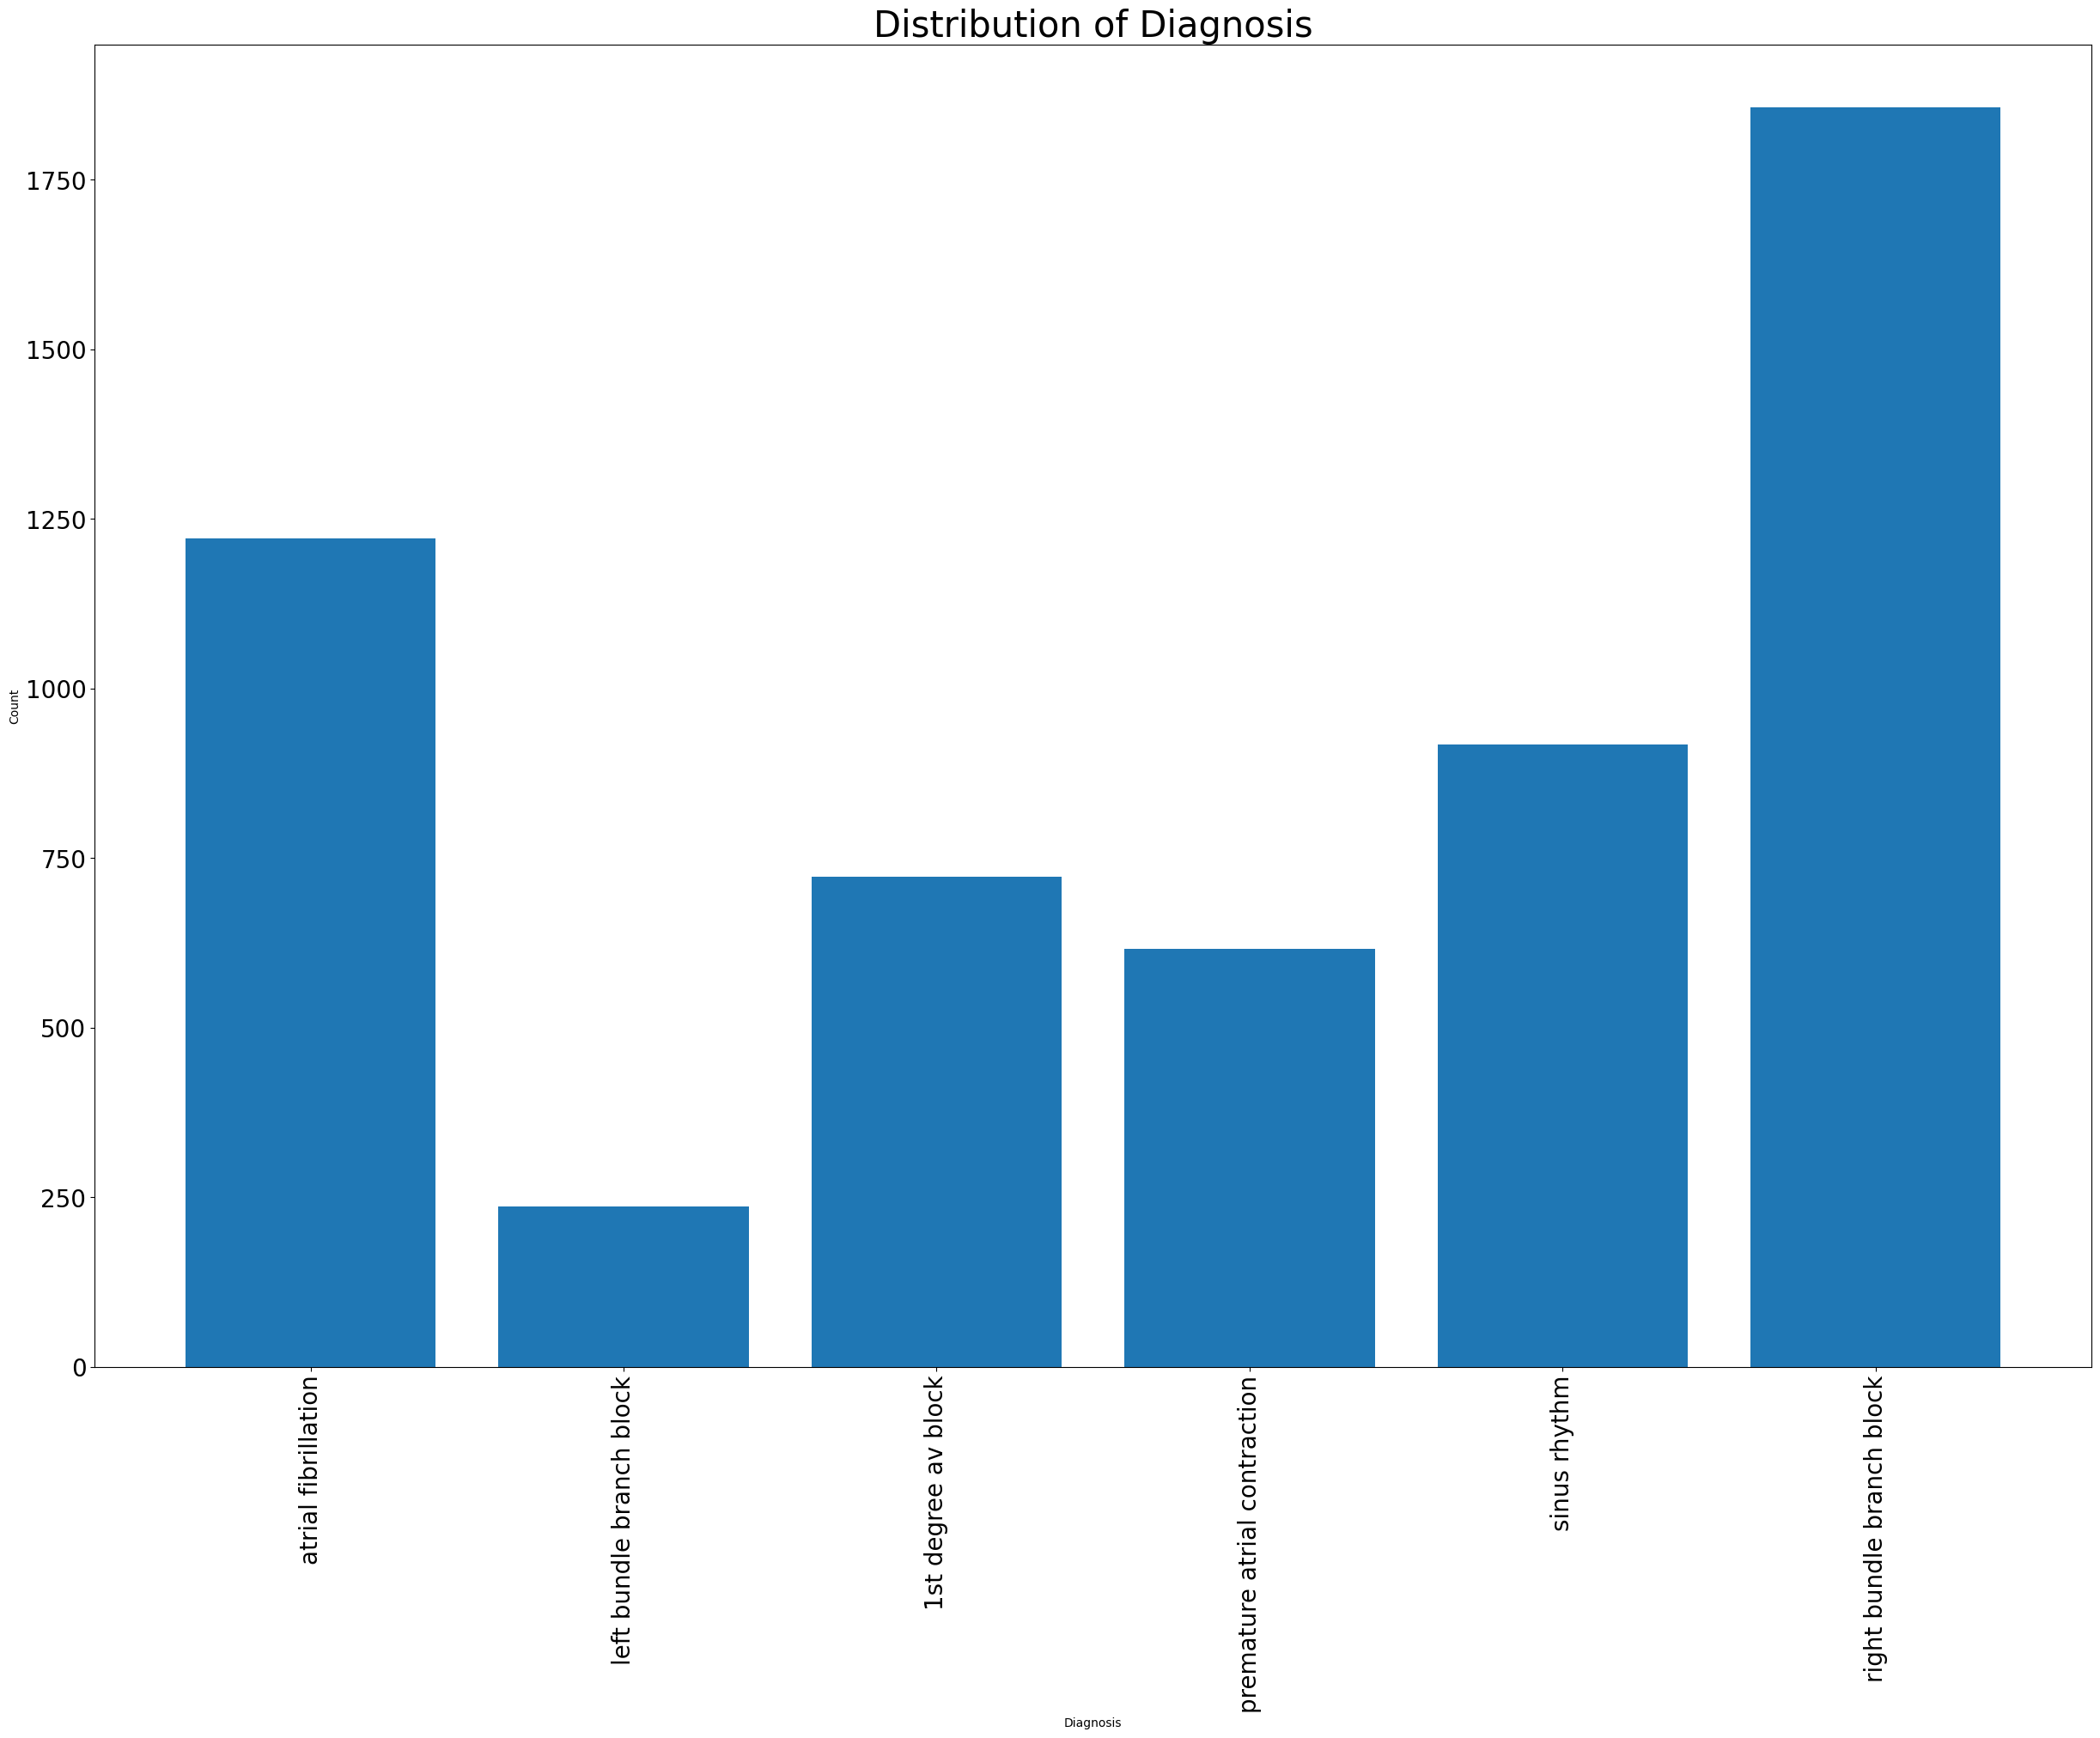

In [ ]:
plot_classes(snomed_classes, SNOMED_scored,y)

In [ ]:
y_all_comb = get_labels_for_all_combinations(y)
print("Total number of unique combinations of diagnosis: {}".format(len(np.unique(y_all_comb))))

Total number of unique combinations of diagnosis: 15


In [ ]:
folds = split_data(labels, y_all_comb)

Training split: 6189
Validation split: 688


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


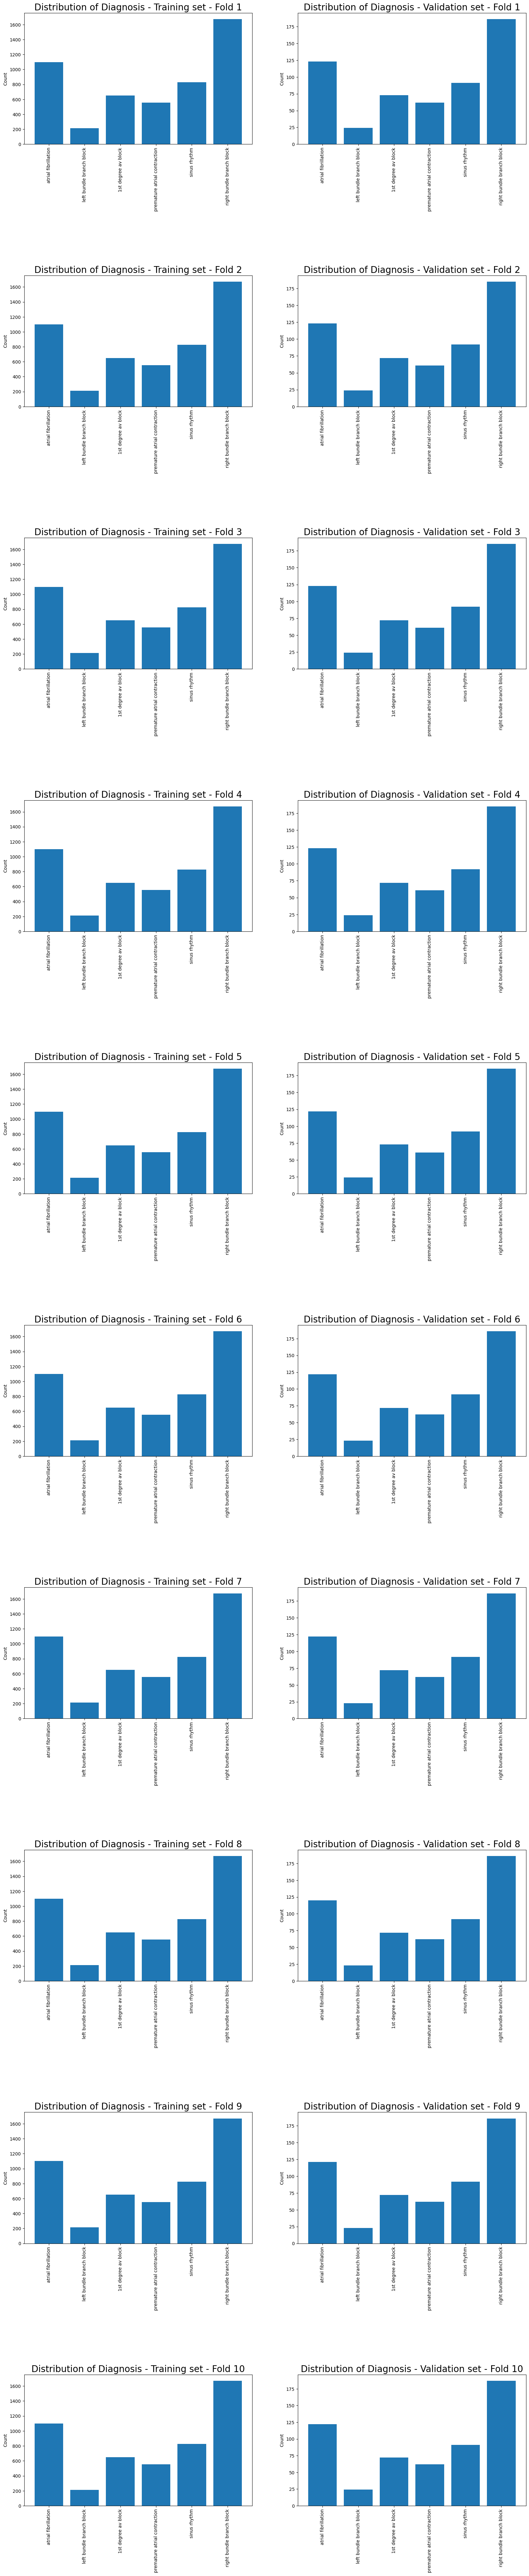

In [ ]:
plot_all_folds(folds,y,snomed_classes)

In [ ]:
order_array = folds[0][0]

#Set up for training

In [ ]:
def shuffle_batch_generator(batch_size, gen_x,gen_y):
    np.random.shuffle(order_array)
    batch_features = np.zeros((batch_size,5000, 12))
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0])) #drop undef class
    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)

        yield batch_features, batch_labels

def generate_y_shuffle(y_train):
    while True:
        for i in order_array:
            y_shuffled = y_train[i]
            yield y_shuffled


def generate_X_shuffle(X_train):
    while True:
        for i in order_array:
                #if filepath.endswith(".mat"):
                    data, header_data = load_challenge_data(X_train[i])
                    X_train_new = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
                    X_train_new = X_train_new.reshape(5000,12)
                    yield X_train_new

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_AUC', factor=0.1, patience=1, verbose=1, mode='max',
    min_delta=0.0001, cooldown=0, min_lr=0
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', mode='max', verbose=1, patience=2)

In [ ]:
def thr_chall_metrics(thr, label, output_prob):
    return compute_challenge_metric_for_opt(label, np.array(output_prob>thr))

In [ ]:
def load_challenge_data(filename):
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data

In [ ]:
def generate_validation_data(ecg_filenames, y,test_order_array):
    y_train_gridsearch=y[test_order_array]
    ecg_filenames_train_gridsearch=ecg_filenames[test_order_array]

    ecg_train_timeseries=[]
    for names in ecg_filenames_train_gridsearch:
        data, header_data = load_challenge_data(names)
        data = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
        ecg_train_timeseries.append(data)
    X_train_gridsearch = np.asarray(ecg_train_timeseries)

    X_train_gridsearch = X_train_gridsearch.reshape(ecg_filenames_train_gridsearch.shape[0],5000,12)

    return X_train_gridsearch, y_train_gridsearch

In [ ]:
def compute_modified_confusion_matrix(labels, outputs):
    # Compute a binary multi-class, multi-label confusion matrix, where the rows
    # are the labels and the columns are the outputs.
    num_recordings, num_classes = np.shape(labels)
    A = np.zeros((num_classes, num_classes))

    # Iterate over all of the recordings.
    for i in range(num_recordings):
        # Calculate the number of positive labels and/or outputs.
        normalization = float(max(np.sum(np.any((labels[i, :], outputs[i, :]), axis=0)), 1))
        # Iterate over all of the classes.
        for j in range(num_classes):
            # Assign full and/or partial credit for each positive class.
            if labels[i, j]:
                for k in range(num_classes):
                    if outputs[i, k]:
                        A[j, k] += 1.0/normalization

    return A
def plot_normalized_conf_matrix_dev(y_pred, ecg_filenames, y, val_fold, threshold, snomedclasses):
    df_cm = pd.DataFrame(compute_modified_confusion_matrix(generate_validation_data(ecg_filenames,y,val_fold)[1], (y_pred>threshold)*1), columns=snomedclasses, index = snomedclasses)
    df_cm = df_cm.fillna(0)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    df_norm_col=(df_cm-df_cm.mean())/df_cm.std()
    plt.figure(figsize = (36,14))
    sns.set(font_scale=1.4)
    sns.heatmap(df_norm_col, cmap="Blues", annot=True,annot_kws={"size": 16},fmt=".2f",cbar=False)# font size

#ANN

In [ ]:
ann_model = Sequential()
ann_model.add(Dense(64, activation='relu', input_shape=(5000,12)))
ann_model.add(Dense(128, activation='relu'))
ann_model.add(Dense(128, activation='relu'))
ann_model.add(Dense(64, activation='relu'))
ann_model.add(GlobalAveragePooling1D())
ann_model.add(Dense(6, activation='sigmoid'))

In [ ]:
ann_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'),
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [ ]:
ann_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 5000, 64)          832       
                                                                 
 dense_26 (Dense)            (None, 5000, 128)         8320      
                                                                 
 dense_27 (Dense)            (None, 5000, 128)         16512     
                                                                 
 dense_28 (Dense)            (None, 5000, 64)          8256      
                                                                 
 global_average_pooling1d_5  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_29 (Dense)            (None, 6)                 390       
                                                      

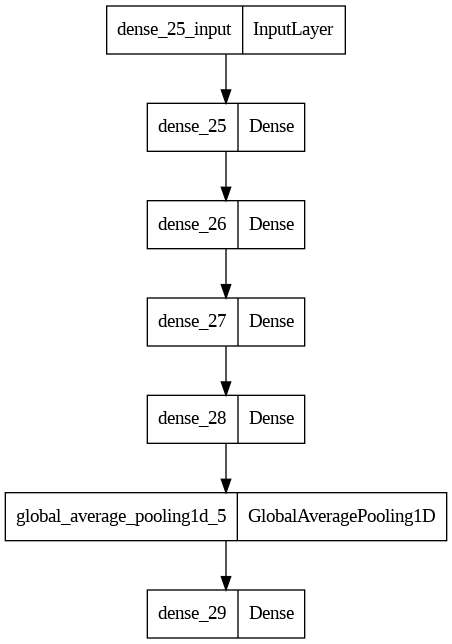

In [ ]:
plot_model(ann_model)

In [ ]:
batchsize = 10
ann_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), gen_y=generate_y_shuffle(y)), epochs=10, steps_per_epoch=(len(order_array)/(batchsize*10)), validation_data=generate_validation_data(ecg_filenames,y,folds[0][1]), callbacks=[reduce_lr,early_stop])

Epoch 1/10
61/61 [==============================] - 13s 95ms/step - loss: 0.8603 - accuracy: 0.8237 - Recall: 0.0940 - Precision: 0.1880 - AUC: 0.4941 - val_loss: 0.4462 - val_accuracy: 0.8566 - val_Recall: 0.0072 - val_Precision: 0.0976 - val_AUC: 0.6219 - lr: 0.0010
Epoch 2/10
62/61 [==============================] - ETA: 0s - loss: 0.4178 - accuracy: 0.8594 - Recall: 0.0996 - Precision: 0.3798 - AUC: 0.5592
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
61/61 [==============================] - 4s 67ms/step - loss: 0.4178 - accuracy: 0.8594 - Recall: 0.0996 - Precision: 0.3798 - AUC: 0.5592 - val_loss: 0.4488 - val_accuracy: 0.7946 - val_Recall: 0.1789 - val_Precision: 0.2045 - val_AUC: 0.6169 - lr: 0.0010
Epoch 3/10
61/61 [==============================] - 4s 64ms/step - loss: 0.3753 - accuracy: 0.8648 - Recall: 0.0270 - Precision: 0.2708 - AUC: 0.5961 - val_loss: 0.3812 - val_accuracy: 0.8646 - val_Recall: 0.0000e+00 - val_Precision: 0.0000e+00 - val_A

In [ ]:
ann_model.save_weights('/content/drive/MyDrive/AdvanceAI_Lab/Final/ann_model_weights.h5')

Text(0, 0.5, 'Accuracy')

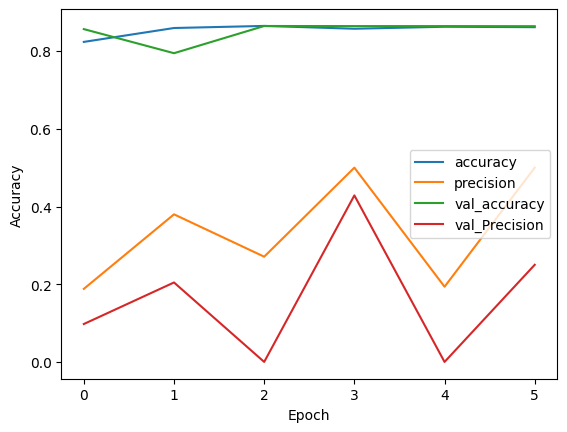

In [ ]:
plt.plot(ann_model.history.history['accuracy'])
plt.plot(ann_model.history.history['Precision'])
plt.plot(ann_model.history.history['val_accuracy'])
plt.plot(ann_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
y_pred = ann_model.predict(x=generate_validation_data(ecg_filenames,y,folds[0][1])[0])

22/22 [==============================] - 0s 15ms/step


In [ ]:
print(y_pred)

[[0.22573455 0.07444506 0.1381757  0.11465057 0.22652504 0.24177761]
 [0.25036076 0.0335682  0.14408462 0.1288693  0.12169496 0.2952227 ]
 [0.3184459  0.04488795 0.1682977  0.16772418 0.1448044  0.32120353]
 ...
 [0.25603825 0.05913245 0.15016995 0.12009507 0.22741555 0.36418518]
 [0.32313457 0.08811539 0.20252155 0.19217324 0.21954527 0.35096917]
 [0.28803903 0.06827768 0.21823746 0.18770099 0.2177776  0.37696162]]


In [ ]:
all_scores = iterate_threshold(y_pred, ecg_filenames, y ,folds[0][1] )

<ipython-input-11-f8d5c289bae9>:788: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  inactive_outputs = np.zeros((num_recordings, num_classes), dtype=np.bool)


0.4985911914824826
0.5218838772258017
0.5269798378715445
0.518647466839111
0.5157871236441182
0.466113921029739
0.3544057984403027
0.21859242322763422
0.06763435645165017
0.012479118070471222
0.00269829172344242
0.0005388885039685289
0.00043880921037437354
0.00043880921037437354
0.00043880921037437354
0.00043880921037437354
0.00043880921037437354
0.0
0.0
0.0


In [ ]:
init_thresholds = np.arange(0,1,0.05)

In [ ]:
new_best_thr = optimize.fmin(thr_chall_metrics, args=(generate_validation_data(ecg_filenames,y,folds[0][1])[1],y_pred), x0=init_thresholds[all_scores.argmax()]*np.ones(6))

<ipython-input-11-f8d5c289bae9>:788: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  inactive_outputs = np.zeros((num_recordings, num_classes), dtype=np.bool)


Optimization terminated successfully.
         Current function value: 0.524267
         Iterations: 37
         Function evaluations: 92


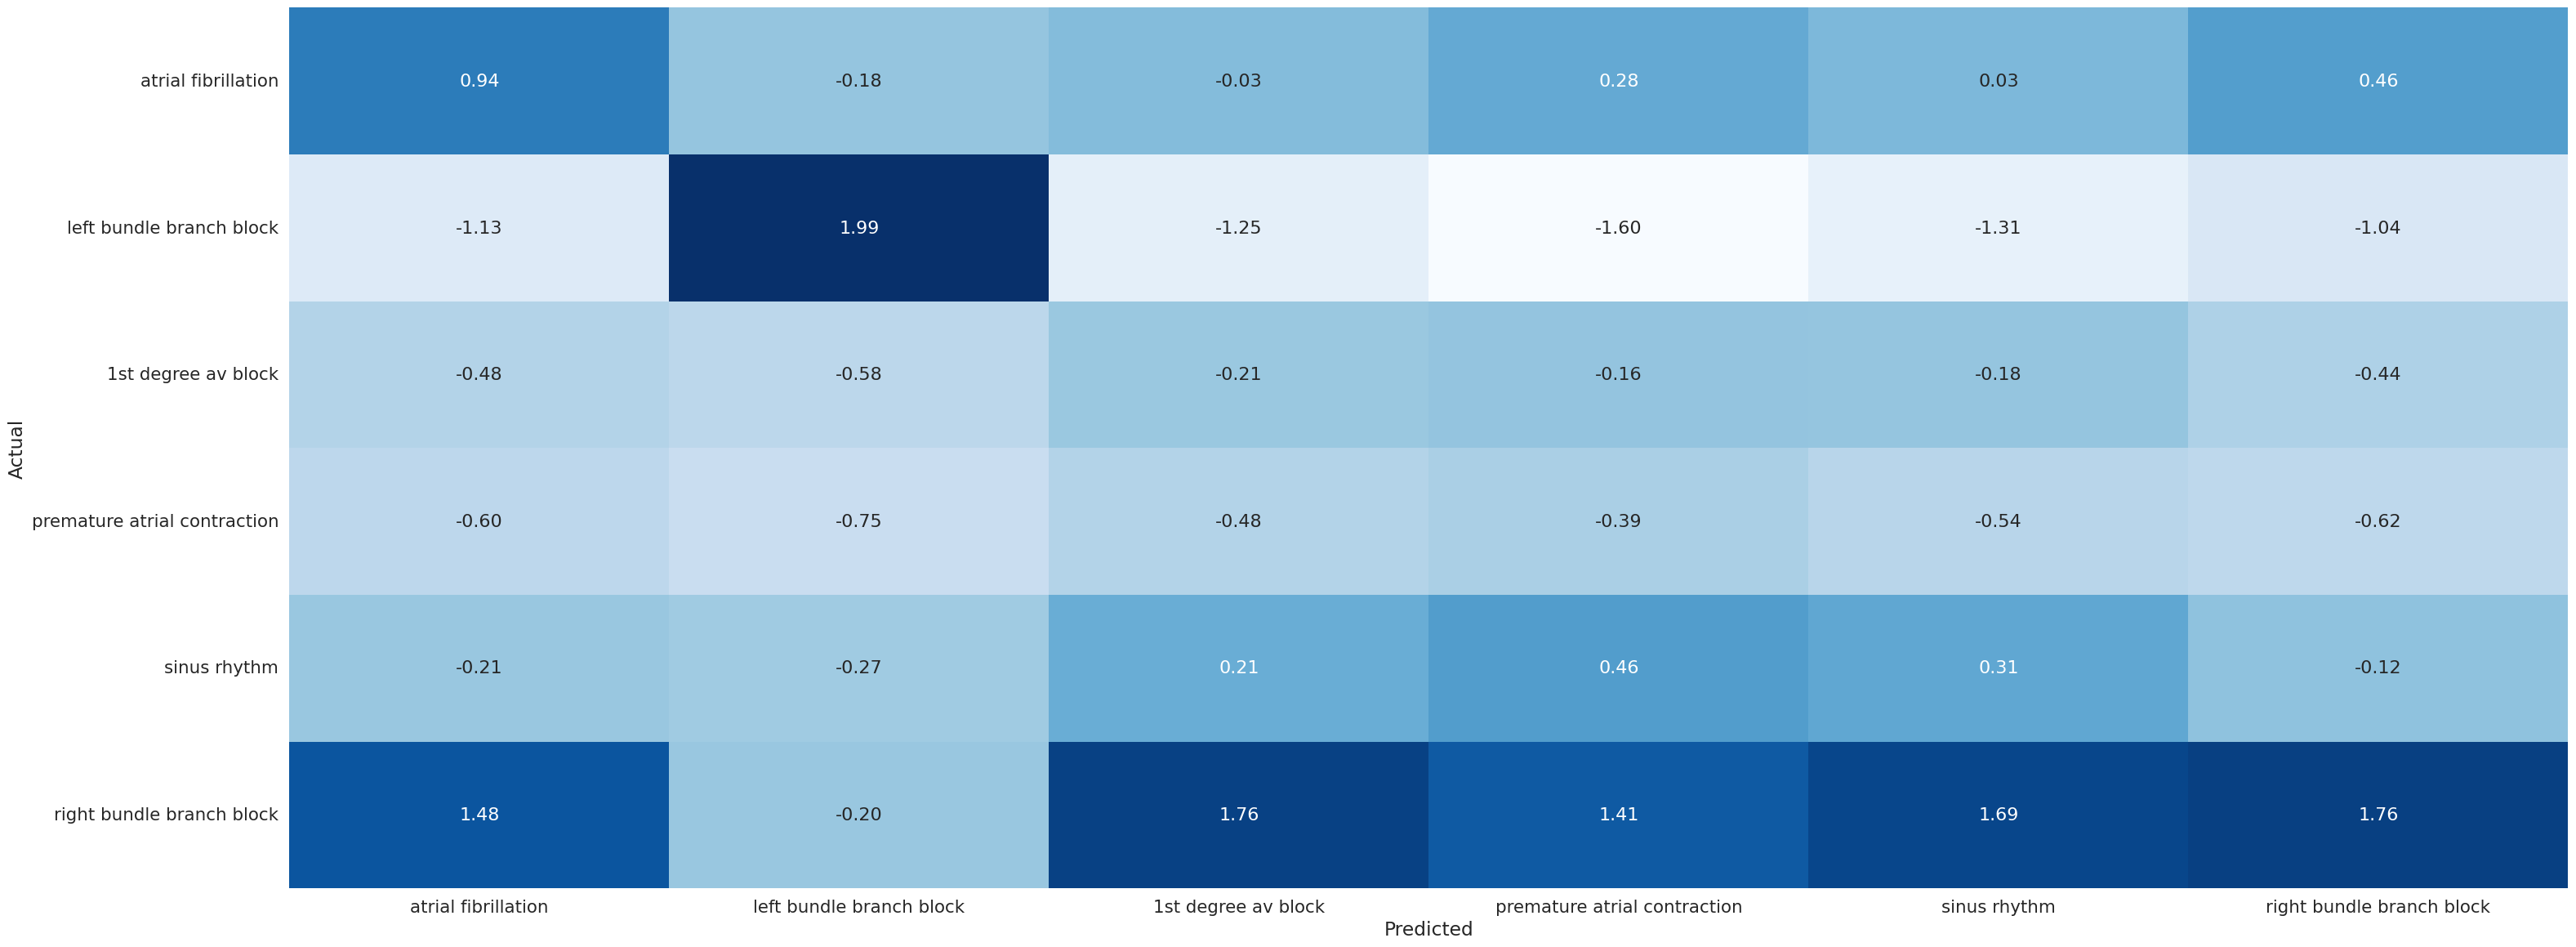

In [ ]:
plot_normalized_conf_matrix_dev(y_pred, ecg_filenames, y, folds[0][1], new_best_thr, snomed_classes)
plt.savefig("/content/drive/MyDrive/AdvanceAI_Lab/Final/confusion_matrix_ann.png", dpi=100)

#LSTM

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(5000,12), return_sequences=True))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(64, activation = 'relu'))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(6, activation = 'sigmoid'))

In [ ]:
 lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'),
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [ ]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5000, 64)          19712     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 6)                 198       
                                                                 
Total params: 55014 (214.90 KB)
Trainable params: 55014 (214.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
batchsize = 10
lstm_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), gen_y=generate_y_shuffle(y)), epochs=10, steps_per_epoch=(len(order_array)/(batchsize*10)), validation_data=generate_validation_data(ecg_filenames,y,folds[0][1]))

Epoch 1/10
61/61 [==============================] - 26s 324ms/step - loss: 0.4684 - accuracy: 0.8172 - Recall: 0.0642 - Precision: 0.1422 - AUC: 0.4584 - val_loss: 0.3770 - val_accuracy: 0.8646 - val_Recall: 0.0000e+00 - val_Precision: 0.0000e+00 - val_AUC: 0.4997
Epoch 2/10
61/61 [==============================] - 17s 280ms/step - loss: 0.4014 - accuracy: 0.8578 - Recall: 0.0364 - Precision: 0.2535 - AUC: 0.4957 - val_loss: 0.3742 - val_accuracy: 0.8646 - val_Recall: 0.0000e+00 - val_Precision: 0.0000e+00 - val_AUC: 0.5357
Epoch 3/10
61/61 [==============================] - 17s 281ms/step - loss: 0.4016 - accuracy: 0.8599 - Recall: 0.0276 - Precision: 0.3415 - AUC: 0.5225 - val_loss: 0.3706 - val_accuracy: 0.8646 - val_Recall: 0.0000e+00 - val_Precision: 0.0000e+00 - val_AUC: 0.5672
Epoch 4/10
61/61 [==============================] - 17s 283ms/step - loss: 0.4038 - accuracy: 0.8618 - Recall: 0.0159 - Precision: 0.2857 - AUC: 0.4926 - val_loss: 0.3700 - val_accuracy: 0.8646 - val_Recal

Text(0, 0.5, 'Accuracy')

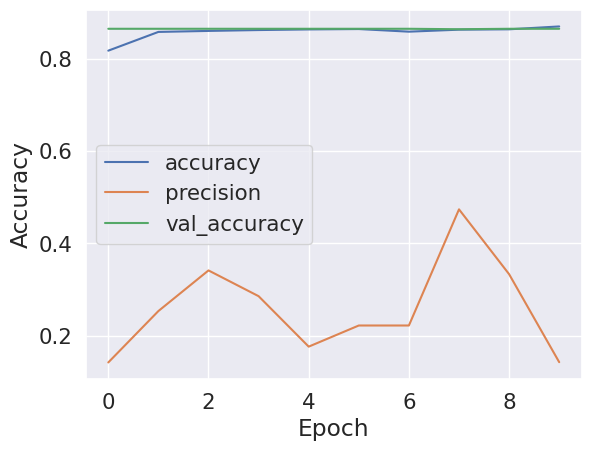

In [ ]:
plt.plot(lstm_model.history.history['accuracy'])
plt.plot(lstm_model.history.history['Precision'])
plt.plot(lstm_model.history.history['val_accuracy'])
plt.legend(("accuracy","precision","val_accuracy"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

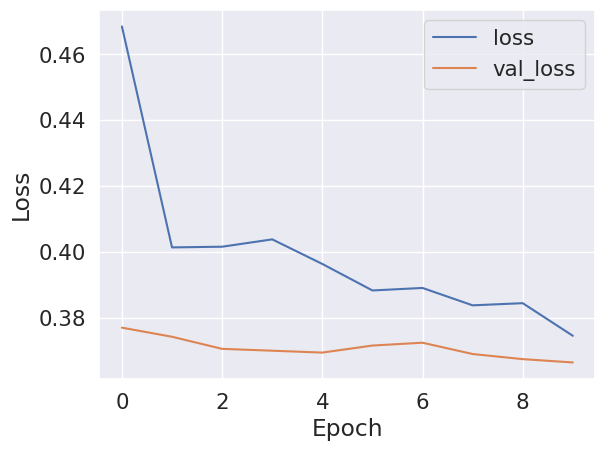

In [ ]:
plt.plot(lstm_model.history.history['loss'])
plt.plot(lstm_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

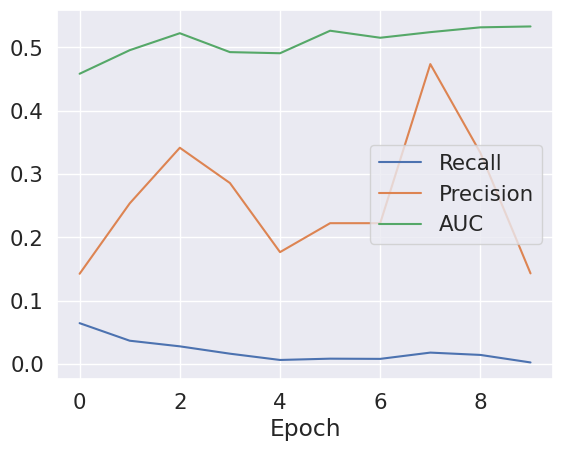

In [ ]:
plt.plot(lstm_model.history.history['Recall'])
plt.plot(lstm_model.history.history['Precision'])
plt.plot(lstm_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [ ]:
from keras.models import load_model
# Save the model weights
lstm_model.save_weights('/content/drive/MyDrive/AdvanceAI_Lab/Final/lstm_model_weights.h5')

In [ ]:
y_pred = lstm_model.predict(x=generate_validation_data(ecg_filenames,y,folds[0][1])[0])

22/22 [==============================] - 4s 142ms/step


In [ ]:
print(y_pred)

In [ ]:
init_thresholds = np.arange(0,1,0.05)

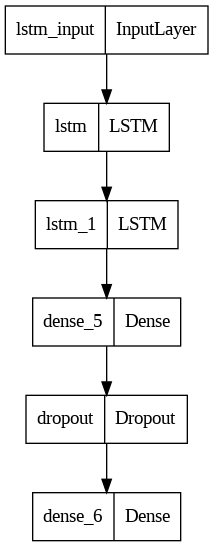

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(lstm_model)

In [ ]:
all_scores = iterate_threshold(y_pred, ecg_filenames, y ,folds[0][1] )

<ipython-input-6-e704d2cf7f32>:810: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  inactive_outputs = np.zeros((num_recordings, num_classes), dtype=np.bool)


0.4985911914824826
0.5088216048099643
0.5174222653333026
0.508204577472921
0.4622008206502075
0.21375397430271678
0.11816670130949906
0.018418439224924366
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [ ]:
new_best_thr = optimize.fmin(thr_chall_metrics, args=(generate_validation_data(ecg_filenames,y,folds[0][1])[1],y_pred), x0=init_thresholds[all_scores.argmax()]*np.ones(6))

<ipython-input-6-e704d2cf7f32>:810: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  inactive_outputs = np.zeros((num_recordings, num_classes), dtype=np.bool)


Optimization terminated successfully.
         Current function value: 0.503166
         Iterations: 39
         Function evaluations: 103


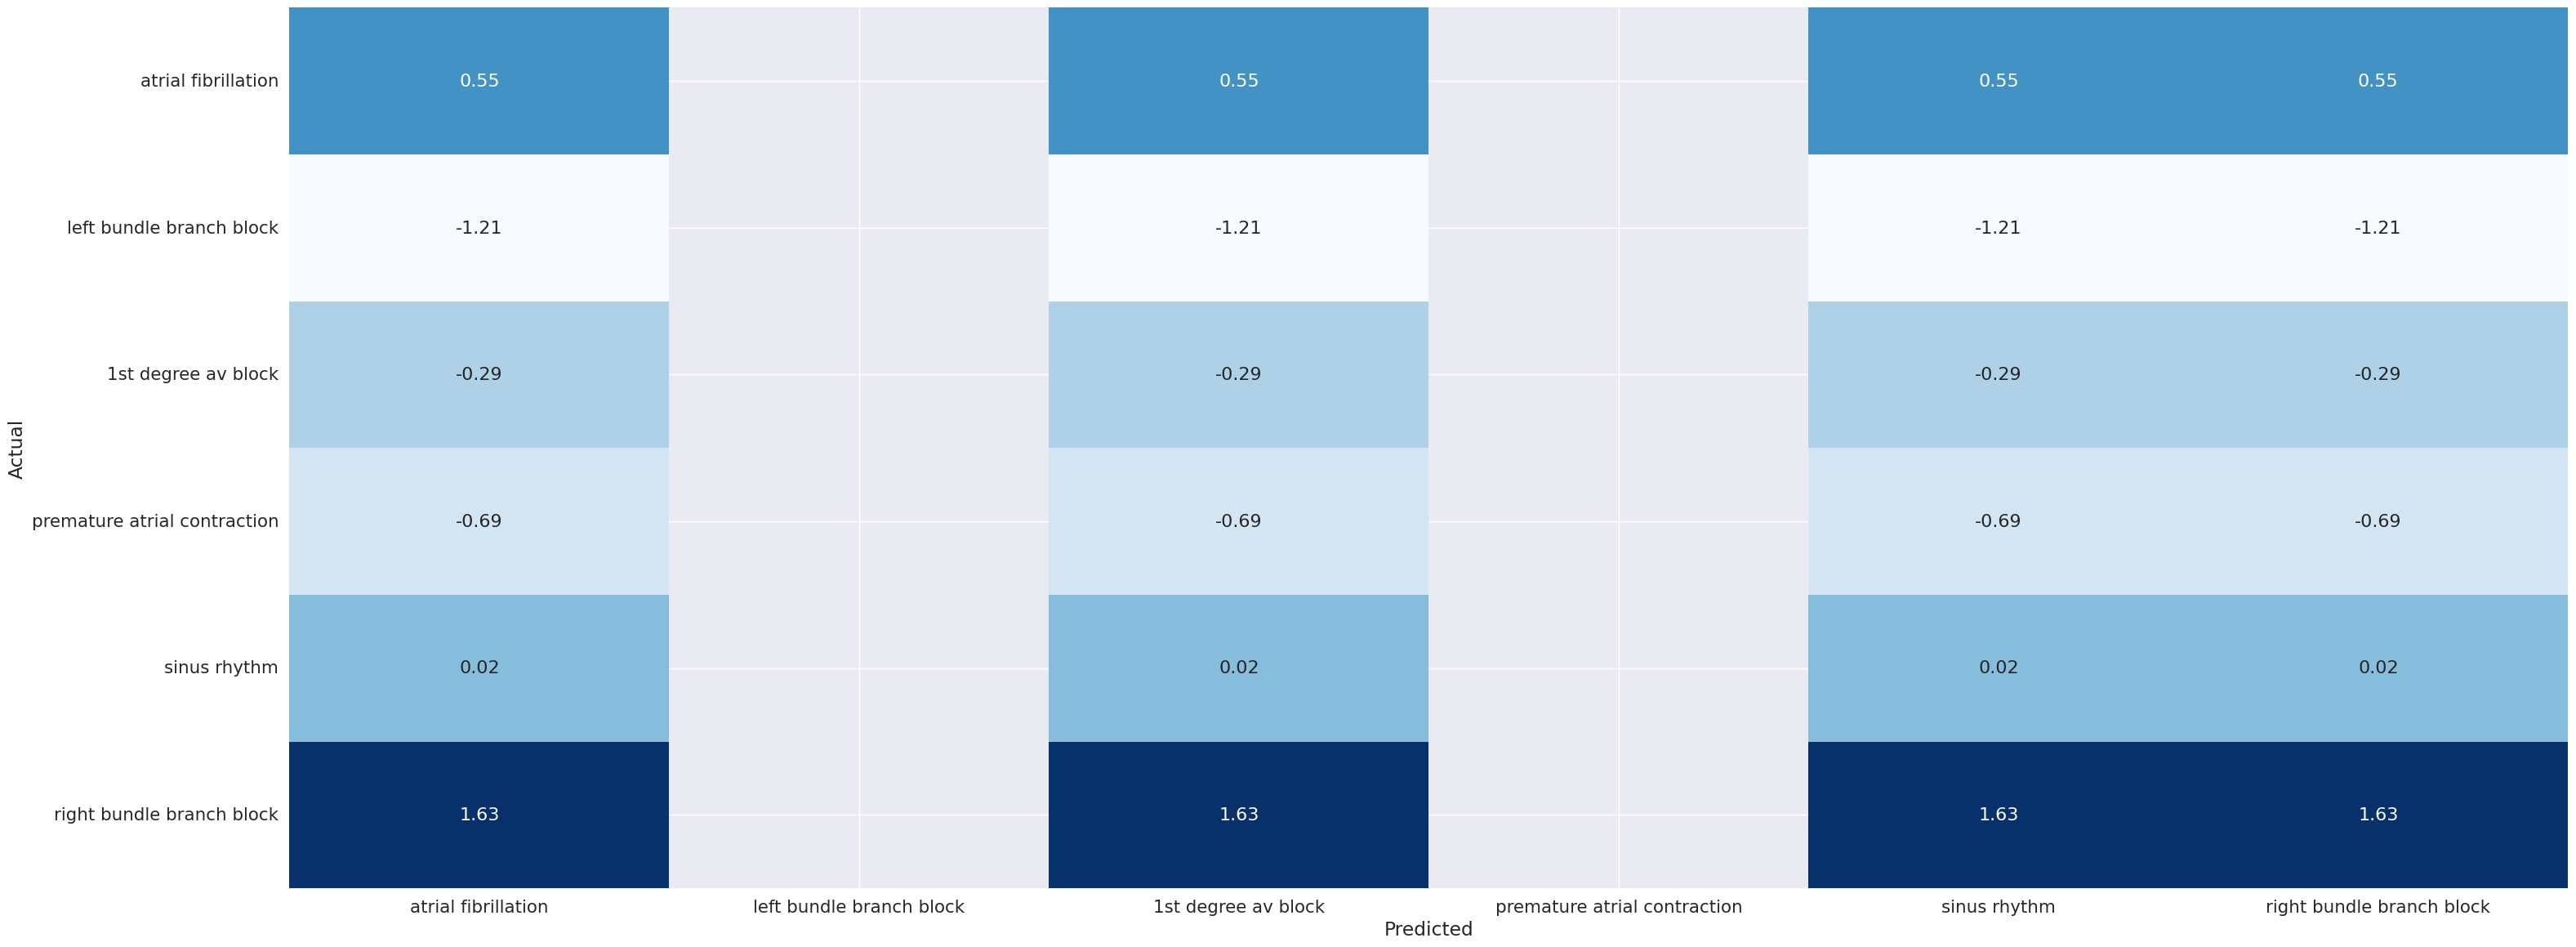

In [ ]:
plot_normalized_conf_matrix_dev(y_pred, ecg_filenames, y, folds[0][1], new_best_thr, snomed_classes)
plt.savefig("/content/drive/MyDrive/AdvanceAI_Lab/Final/confusion_matrix_lstm.png", dpi=100)

#AlexNet

In [ ]:
alexNet_model=Sequential()

alexNet_model.add(Conv1D(filters=96, kernel_size=11, strides=4, input_shape=(5000,12)))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=256, kernel_size=5, padding='same'))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=384, padding='same', kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(Conv1D(filters=384, kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(Conv1D(filters=256, kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(GlobalAveragePooling1D())
alexNet_model.add(Dense(128, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(128, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(6, activation='sigmoid'))

In [ ]:
alexNet_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'),
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [ ]:
alexNet_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1248, 96)          12768     
                                                                 
 batch_normalization (Batch  (None, 1248, 96)          384       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 1248, 96)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 624, 96)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 624, 256)          123136    
                                                                 
 batch_normalization_1 (Bat  (None, 624, 256)         

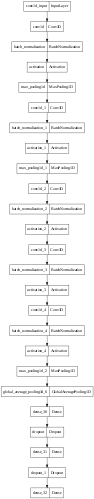

In [ ]:
plot_model(alexNet_model, dpi = 20)

In [ ]:
batchsize = 10
alexNet_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), gen_y=generate_y_shuffle(y)), epochs=10, steps_per_epoch=(len(order_array)/(batchsize*10)), validation_data=generate_validation_data(ecg_filenames,y,folds[0][1]), callbacks=[reduce_lr,early_stop])

Epoch 1/10
61/61 [==============================] - 15s 80ms/step - loss: 0.4298 - accuracy: 0.8304 - Recall: 0.0646 - Precision: 0.1774 - AUC: 0.5589 - val_loss: 0.5058 - val_accuracy: 0.8653 - val_Recall: 0.0215 - val_Precision: 0.5714 - val_AUC: 0.5500 - lr: 0.0010
Epoch 2/10
61/61 [==============================] - 4s 60ms/step - loss: 0.3758 - accuracy: 0.8637 - Recall: 0.0361 - Precision: 0.4091 - AUC: 0.5887 - val_loss: 0.3759 - val_accuracy: 0.8646 - val_Recall: 0.0000e+00 - val_Precision: 0.0000e+00 - val_AUC: 0.6742 - lr: 0.0010
Epoch 3/10
62/61 [==============================] - ETA: 0s - loss: 0.3655 - accuracy: 0.8608 - Recall: 0.0716 - Precision: 0.4138 - AUC: 0.6295
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
61/61 [==============================] - 4s 67ms/step - loss: 0.3655 - accuracy: 0.8608 - Recall: 0.0716 - Precision: 0.4138 - AUC: 0.6295 - val_loss: 0.4617 - val_accuracy: 0.8152 - val_Recall: 0.1038 - val_Precision: 0.1813 - val_A

In [ ]:
alexNet_model.save_weights('/content/drive/MyDrive/AdvanceAI_Lab/Final/alexNet_model_weights.h5')

Text(0, 0.5, 'Accuracy')

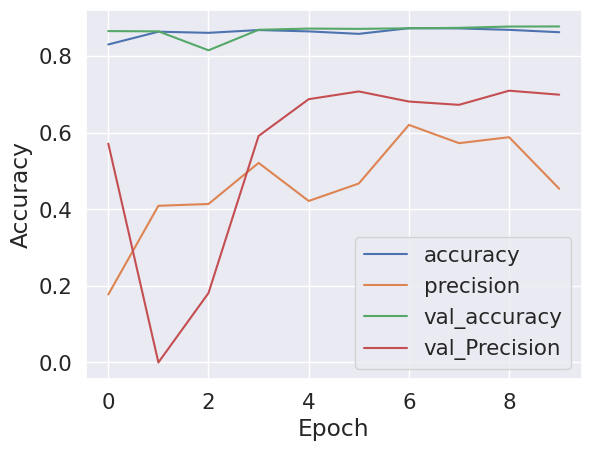

In [ ]:
plt.plot(alexNet_model.history.history['accuracy'])
plt.plot(alexNet_model.history.history['Precision'])
plt.plot(alexNet_model.history.history['val_accuracy'])
plt.plot(alexNet_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

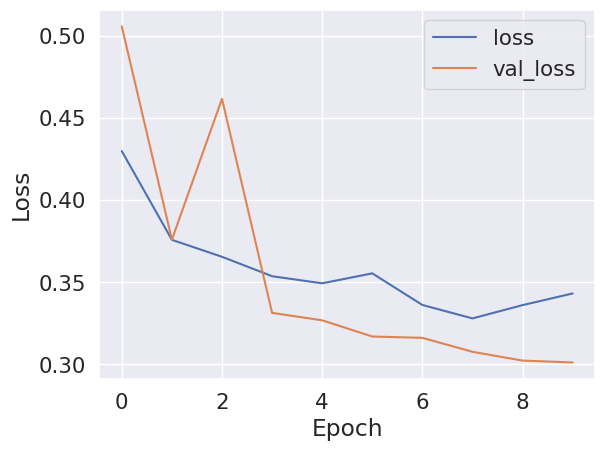

In [ ]:
plt.plot(alexNet_model.history.history['loss'])
plt.plot(alexNet_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

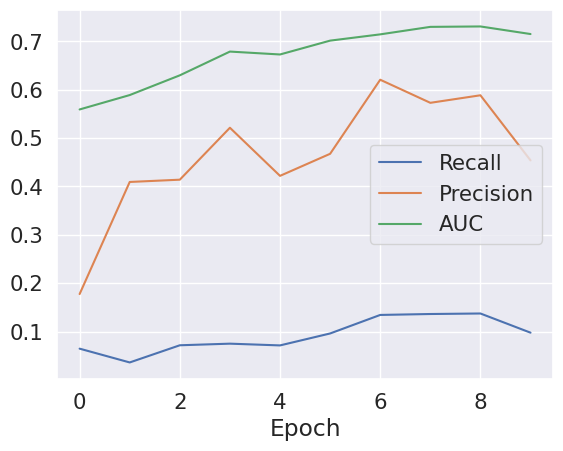

In [ ]:
plt.plot(alexNet_model.history.history['Recall'])
plt.plot(alexNet_model.history.history['Precision'])
plt.plot(alexNet_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [ ]:
y_pred = alexNet_model.predict(x=generate_validation_data(ecg_filenames,y,folds[0][1])[0])

22/22 [==============================] - 0s 19ms/step


In [ ]:
print(y_pred)

[[0.12651674 0.03953201 0.18193425 0.12138623 0.18039946 0.2952396 ]
 [0.22274274 0.03088865 0.17162357 0.12002128 0.10754342 0.324169  ]
 [0.29006445 0.02625911 0.1586072  0.12734562 0.09073804 0.32205275]
 ...
 [0.01164761 0.00348874 0.07957297 0.05927479 0.33695534 0.22753176]
 [0.2978731  0.02366468 0.15289234 0.12579381 0.10030281 0.35961112]
 [0.17224108 0.01692826 0.15557031 0.09888636 0.09197661 0.30815625]]


In [ ]:
init_thresholds = np.arange(0,1,0.05)

In [ ]:
all_scores = iterate_threshold(y_pred, ecg_filenames, y ,folds[0][1] )

<ipython-input-11-f8d5c289bae9>:788: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  inactive_outputs = np.zeros((num_recordings, num_classes), dtype=np.bool)


0.4985911914824826
0.5639133313317475
0.6046606157186081
0.6146092673425869
0.6259536401918443
0.6182090425490966
0.5698130056891231
0.4942223453967375
0.3738808440533654
0.24746529942954804
0.1731795191574863
0.09112219681747848
0.05620222176031779
0.04068223284602416
0.01080856370816878
0.0036952354557841984
0.0018476177278920992
0.0
0.0
0.0


In [ ]:
new_best_thr = optimize.fmin(thr_chall_metrics, args=(generate_validation_data(ecg_filenames,y,folds[0][1])[1],y_pred), x0=init_thresholds[all_scores.argmax()]*np.ones(6))

<ipython-input-11-f8d5c289bae9>:788: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  inactive_outputs = np.zeros((num_recordings, num_classes), dtype=np.bool)


Optimization terminated successfully.
         Current function value: 0.612934
         Iterations: 55
         Function evaluations: 132


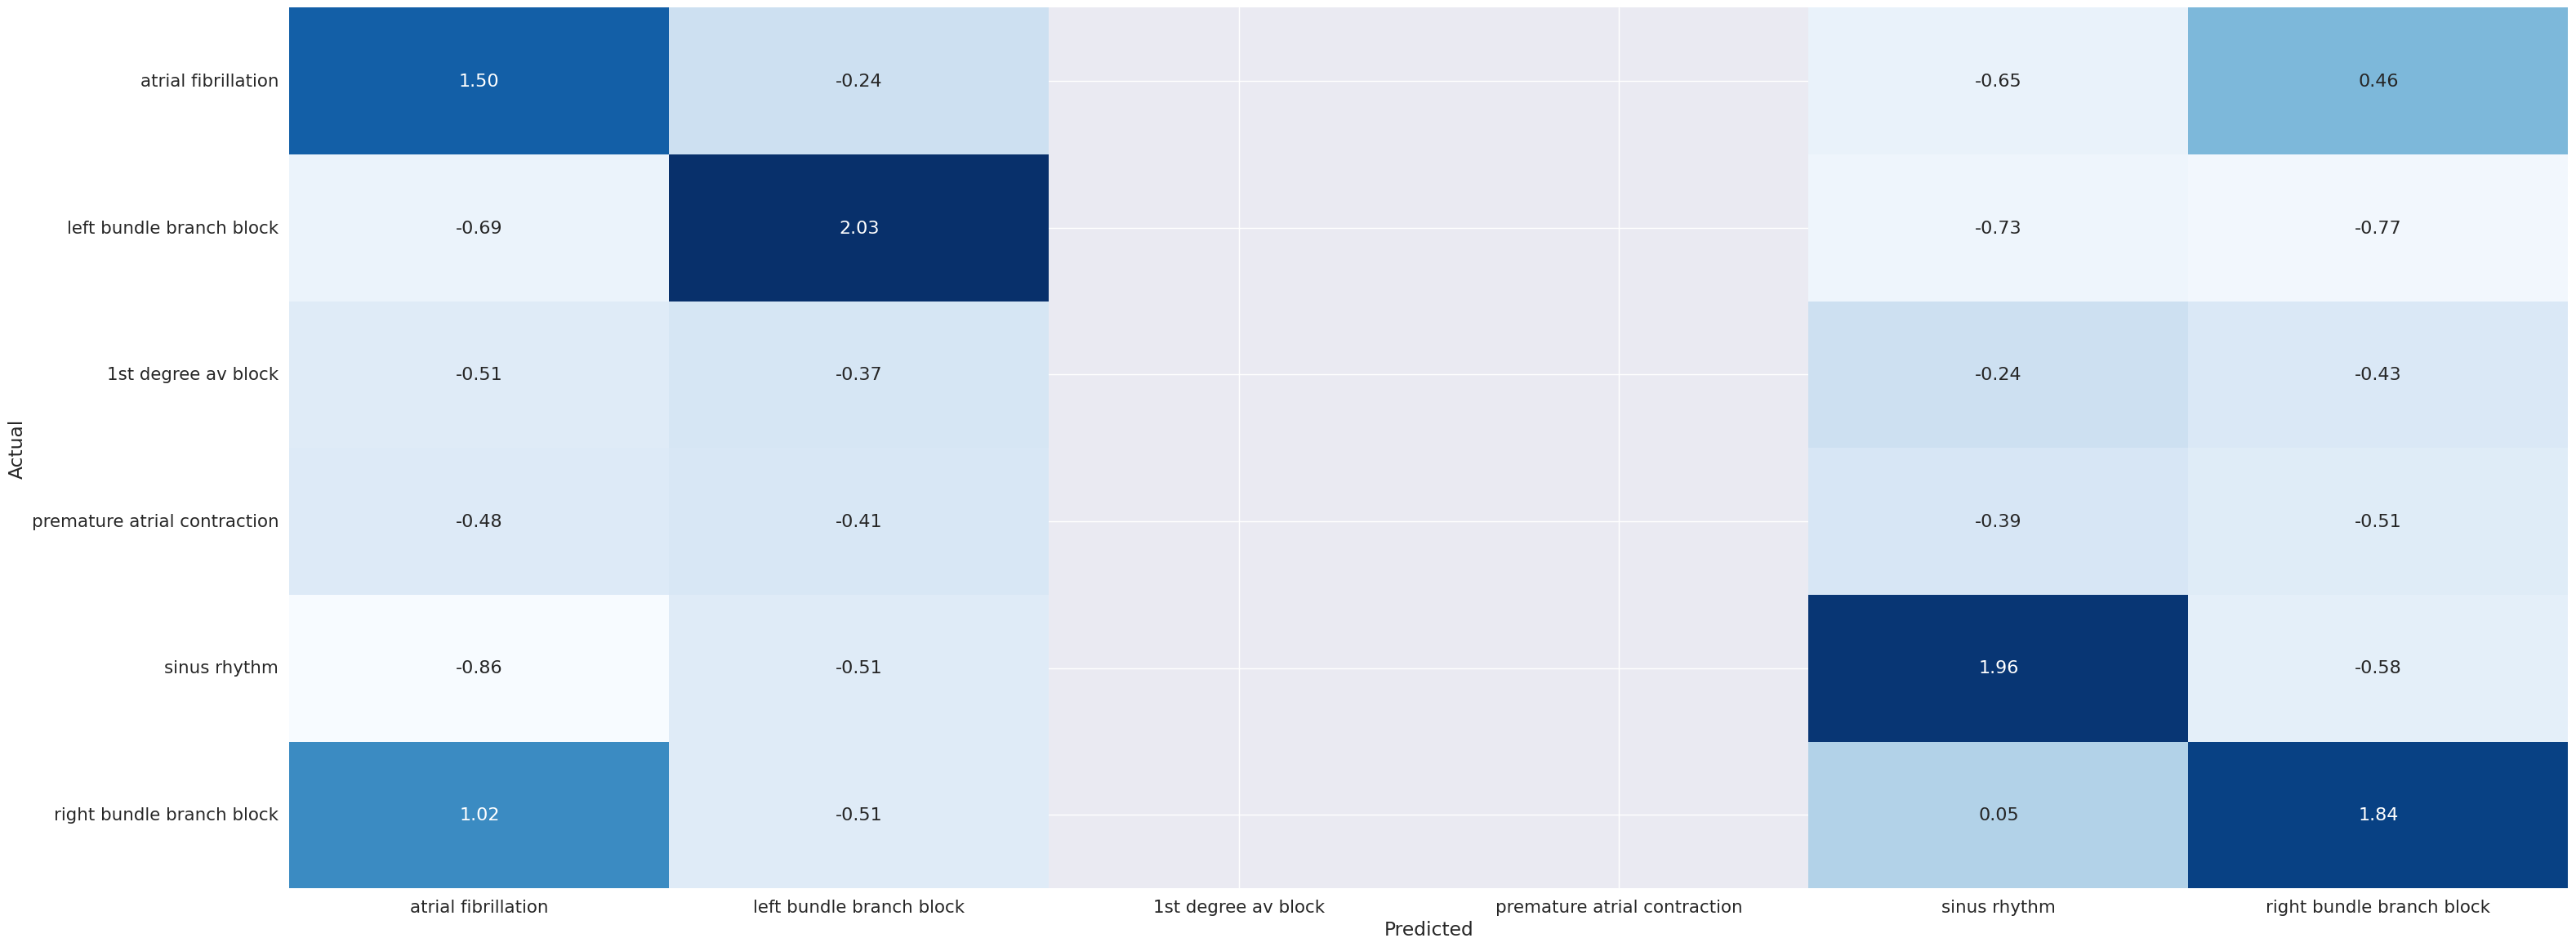

In [ ]:
plot_normalized_conf_matrix_dev(y_pred, ecg_filenames, y, folds[0][1], new_best_thr, snomed_classes)
plt.savefig("/content/drive/MyDrive/AdvanceAI_Lab/Final/confusion_matrix_alexnet.png")

#Resnet

In [ ]:
def identity_block(X, f, filters):
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv1D(filters = F1, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)

    X = Conv1D(filters = F2, kernel_size = f, activation='relu', strides = 1, padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(filters = F3, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, s = 2):
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv1D(F1, 1, activation='relu', strides = s)(X)
    X = BatchNormalization()(X)

    X = Conv1D(F2, f, activation='relu', strides = 1,padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(F3, 1, strides = 1)(X)
    X = BatchNormalization()(X)

    X_shortcut = Conv1D(F3, 1, strides = s)(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)

    return X

def ResNet50(input_shape):

    X_input = Input(input_shape)

    X = ZeroPadding1D(3)(X_input)

    X = Conv1D(64, 7, strides = 2)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)

    X = GlobalAveragePooling1D()(X)
    X = Dense(6,activation='sigmoid')(X)

    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
resNet50_model = ResNet50(input_shape = (5000,12))

In [ ]:
resNet50_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'),
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [ ]:
resNet50_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5000, 12)]           0         []                            
                                                                                                  
 zero_padding1d (ZeroPaddin  (None, 5006, 12)             0         ['input_1[0][0]']             
 g1D)                                                                                             
                                                                                                  
 conv1d_5 (Conv1D)           (None, 2500, 64)             5440      ['zero_padding1d[0][0]']      
                                                                                                  
 batch_normalization_5 (Bat  (None, 2500, 64)             256       ['conv1d_5[0][0]']     

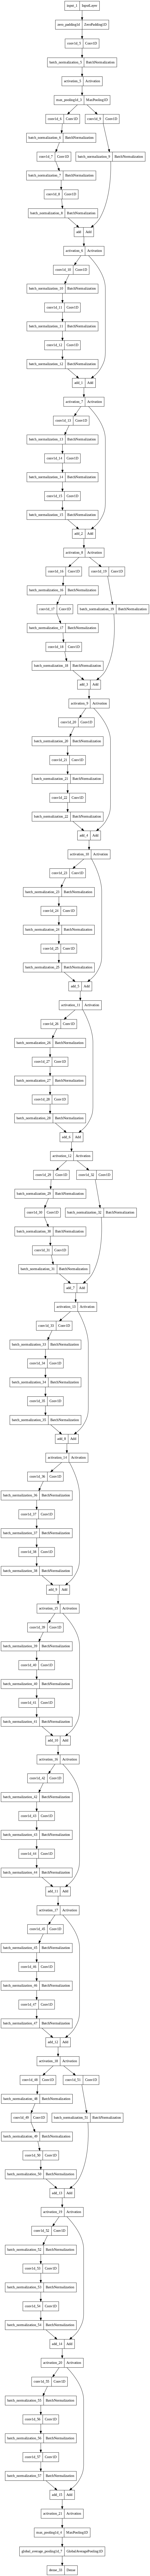

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(resNet50_model, dpi = 100)

In [ ]:
batchsize = 10
resNet50_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), gen_y=generate_y_shuffle(y)), epochs=10, steps_per_epoch=(len(order_array)/(batchsize*10)), validation_data=generate_validation_data(ecg_filenames,y,folds[0][1]))

Epoch 1/10
61/61 [==============================] - 69s 408ms/step - loss: 0.5597 - accuracy: 0.8239 - Recall: 0.1046 - Precision: 0.1985 - AUC: 0.5423 - val_loss: 20.3609 - val_accuracy: 0.6485 - val_Recall: 0.4132 - val_Precision: 0.1706 - val_AUC: 0.5237
Epoch 2/10
61/61 [==============================] - 18s 285ms/step - loss: 0.4647 - accuracy: 0.8433 - Recall: 0.1332 - Precision: 0.2889 - AUC: 0.5574 - val_loss: 3.2175 - val_accuracy: 0.7534 - val_Recall: 0.2236 - val_Precision: 0.1763 - val_AUC: 0.4831
Epoch 3/10
61/61 [==============================] - 18s 286ms/step - loss: 0.4227 - accuracy: 0.8444 - Recall: 0.1230 - Precision: 0.3264 - AUC: 0.5984 - val_loss: 1.1812 - val_accuracy: 0.8045 - val_Recall: 0.0894 - val_Precision: 0.1437 - val_AUC: 0.5377
Epoch 4/10
61/61 [==============================] - 23s 370ms/step - loss: 0.3979 - accuracy: 0.8540 - Recall: 0.1509 - Precision: 0.3827 - AUC: 0.6167 - val_loss: 1.5827 - val_accuracy: 0.6969 - val_Recall: 0.1896 - val_Precisi

In [ ]:
resNet50_model.save_weights('/content/drive/MyDrive/AdvanceAI_Lab/Final/resNet50_model_weight.h5')

Text(0, 0.5, 'Accuracy')

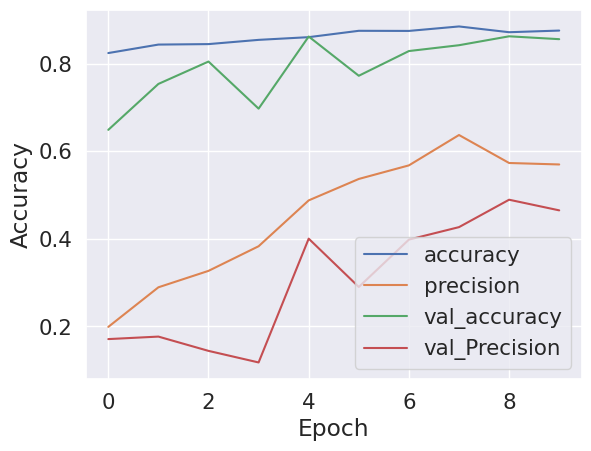

In [ ]:
plt.plot(resNet50_model.history.history['accuracy'])
plt.plot(resNet50_model.history.history['Precision'])
plt.plot(resNet50_model.history.history['val_accuracy'])
plt.plot(resNet50_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

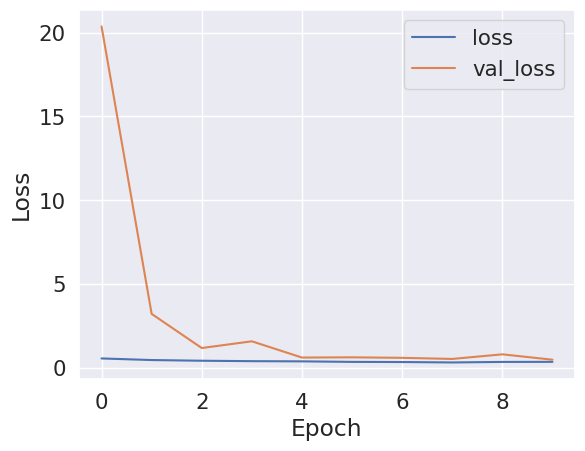

In [ ]:
plt.plot(resNet50_model.history.history['loss'])
plt.plot(resNet50_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

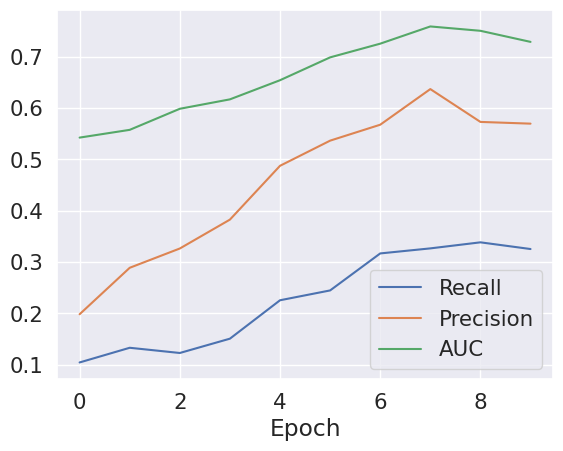

In [ ]:
plt.plot(resNet50_model.history.history['Recall'])
plt.plot(resNet50_model.history.history['Precision'])
plt.plot(resNet50_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [ ]:
y_pred = resNet50_model.predict(x=generate_validation_data(ecg_filenames,y,folds[0][1])[0])

22/22 [==============================] - 5s 149ms/step


In [ ]:
init_thresholds = np.arange(0,1,0.05)
all_scores = iterate_threshold(y_pred, ecg_filenames, y ,folds[0][1] )

<ipython-input-11-f8d5c289bae9>:788: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  inactive_outputs = np.zeros((num_recordings, num_classes), dtype=np.bool)


0.49821242984826475
0.5791280784005788
0.5966323317705565
0.5900001539681441
0.5746957204554378
0.5529996843653049
0.5383707860843591
0.5311900967689785
0.5121673325788895
0.49310992555640243
0.47377537587473156
0.45400201698268633
0.43484453066660506
0.42458255386960436
0.38104036274894726
0.362637320338422
0.3360547202783744
0.30196617319876523
0.2780972616765591
0.24199943031786725


In [ ]:
new_best_thr = optimize.fmin(thr_chall_metrics, args=(generate_validation_data(ecg_filenames,y,folds[0][1])[1],y_pred), x0=init_thresholds[all_scores.argmax()]*np.ones(6))

<ipython-input-11-f8d5c289bae9>:788: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  inactive_outputs = np.zeros((num_recordings, num_classes), dtype=np.bool)


Optimization terminated successfully.
         Current function value: 0.595183
         Iterations: 16
         Function evaluations: 66


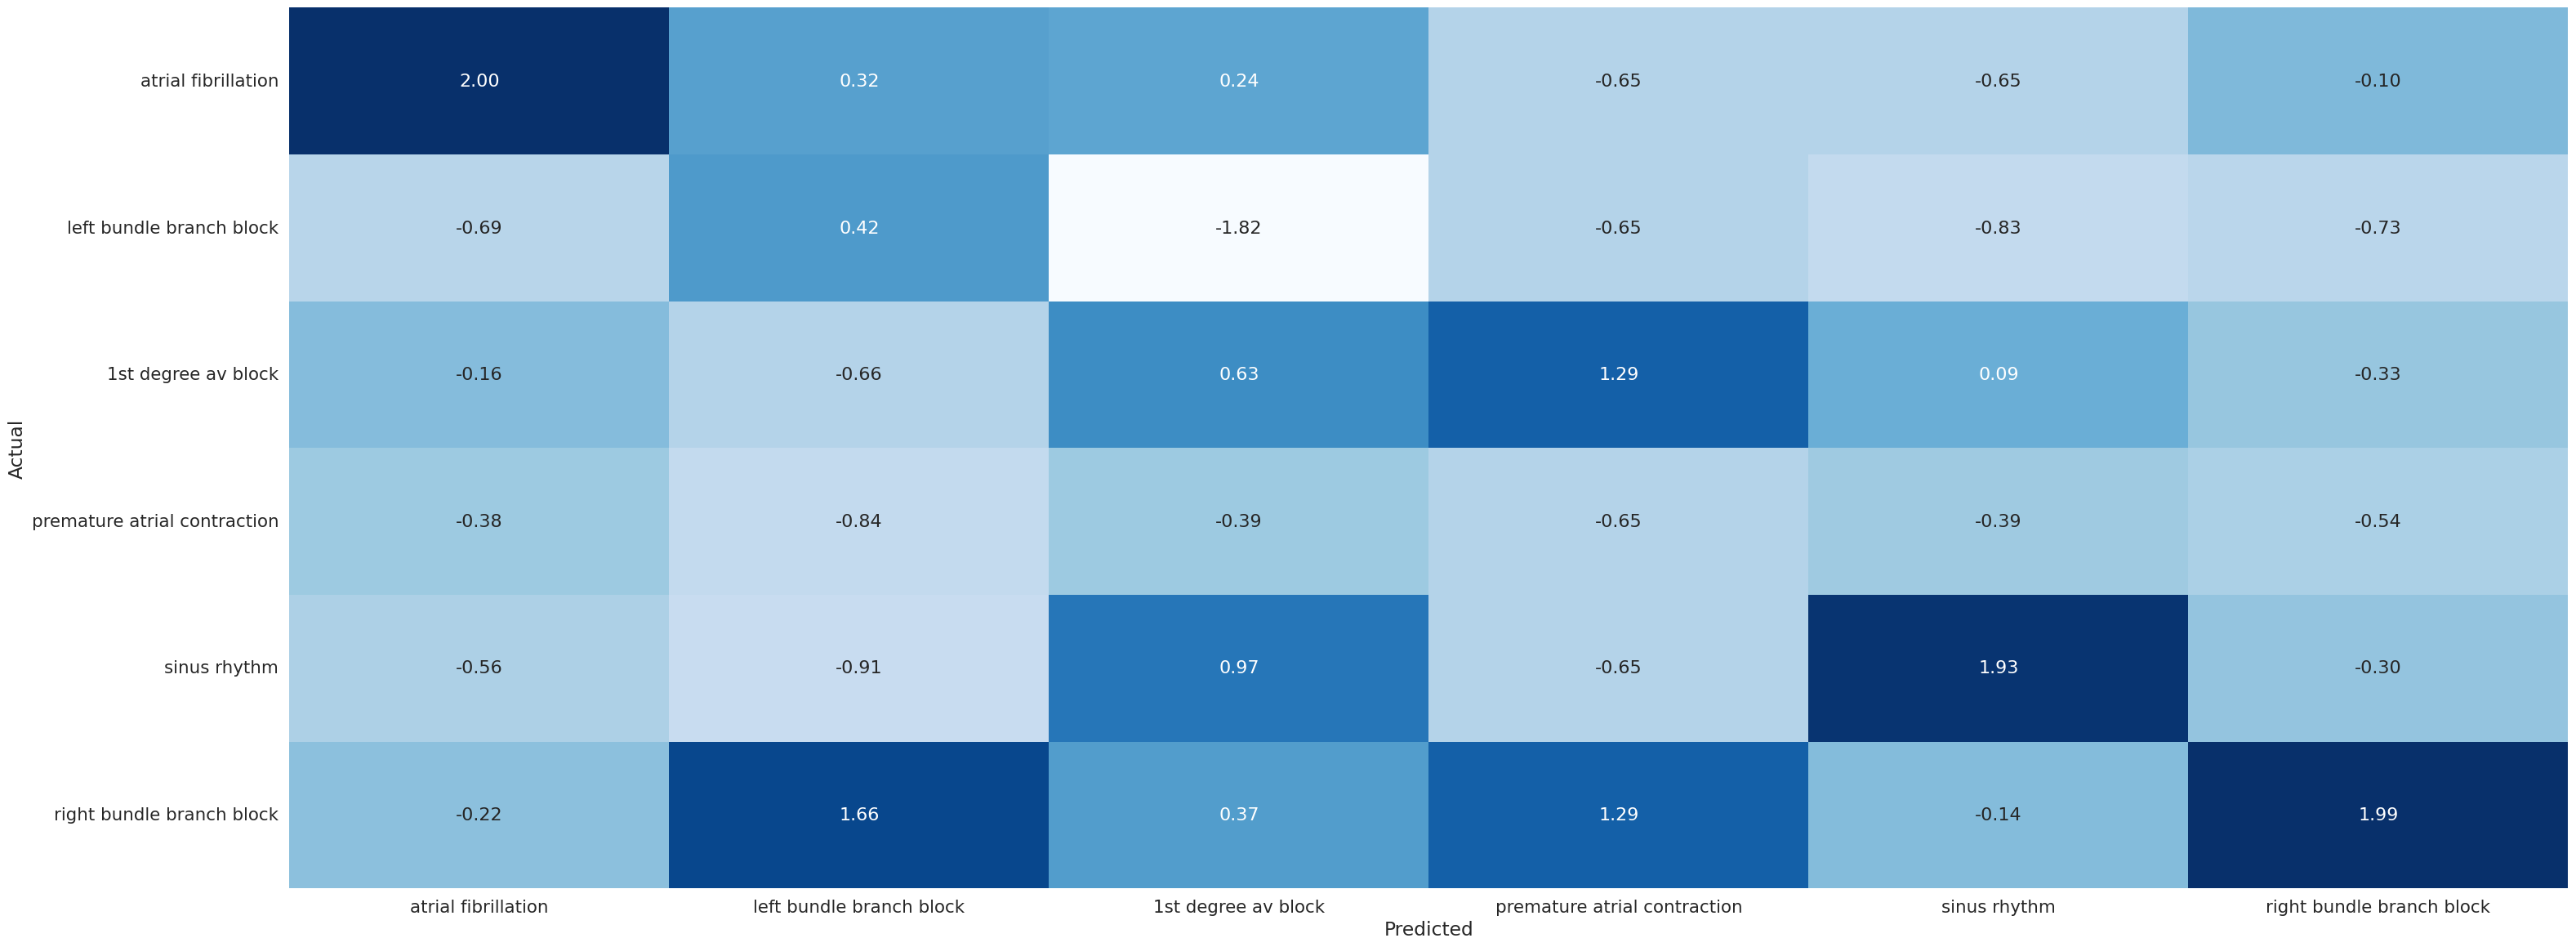

In [ ]:
plot_normalized_conf_matrix_dev(y_pred, ecg_filenames, y, folds[0][1], new_best_thr, snomed_classes)
plt.savefig("/content/drive/MyDrive/AdvanceAI_Lab/Final/confusion_matrix_resnet50.png", dpi=100)

#Load model

Resnet

In [ ]:
import tensorflow as tf

def identity_block(X, f, filters):
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv1D(filters = F1, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)

    X = Conv1D(filters = F2, kernel_size = f, activation='relu', strides = 1, padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(filters = F3, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, s = 2):
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv1D(F1, 1, activation='relu', strides = s)(X)
    X = BatchNormalization()(X)

    X = Conv1D(F2, f, activation='relu', strides = 1,padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(F3, 1, strides = 1)(X)
    X = BatchNormalization()(X)

    X_shortcut = Conv1D(F3, 1, strides = s)(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)

    return X

def ResNet50(input_shape):

    X_input = Input(input_shape)

    X = ZeroPadding1D(3)(X_input)

    X = Conv1D(64, 7, strides = 2)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)

    X = GlobalAveragePooling1D()(X)
    X = Dense(6,activation='sigmoid')(X)

    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model


ANN

In [ ]:
ann_model = Sequential()
ann_model.add(Dense(50, activation='relu', input_shape=(5000,12)))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(GlobalAveragePooling1D())
ann_model.add(Dense(6, activation='sigmoid'))

In [ ]:
#resNet50_model_load = ResNet50(input_shape = (5000,12))
# Load weights
ann_model.load_weights('/content/drive/MyDrive/AdvanceAI_Lab/Final/ann_model_weights.h5')

In [ ]:
gender_test, age_test, labels_test, ecg_filenames_test = import_key_data("/content/Test")
ecg_filenames_test = np.asarray(ecg_filenames_test)

In [ ]:
new_signal =shuffle_batch_generator(batch_size=10, gen_x=generate_X_shuffle(ecg_filenames_test), gen_y=generate_y_shuffle(y))

In [ ]:
type(new_signal)

generator

In [ ]:
x7=shuffle_batch_generator(batch_size=10, gen_x=generate_X_shuffle(ecg_filenames), gen_y=generate_y_shuffle(y))

In [ ]:
y_pred = ann_model.predict(x=generate_validation_data(ecg_filenames,y,folds[0][1])[0])

22/22 [==============================] - 0s 11ms/step


In [ ]:
print(y_pred)

[[1.0000000e+00 4.8152160e-06 2.8647423e-01 9.9999976e-01 4.1559108e-02
  1.0000000e+00]
 [1.0000000e+00 5.8398589e-05 5.7132679e-01 9.9995077e-01 1.4450607e-01
  1.0000000e+00]
 [1.0000000e+00 2.4106794e-04 5.9701043e-01 9.9964511e-01 1.8678911e-01
  1.0000000e+00]
 ...
 [1.0000000e+00 1.4116342e-05 3.0033702e-01 9.9999905e-01 5.7546515e-02
  1.0000000e+00]
 [1.0000000e+00 2.7237370e-04 4.9131608e-01 9.9990952e-01 1.2638512e-01
  1.0000000e+00]
 [1.0000000e+00 4.2724964e-04 4.6045163e-01 9.9986625e-01 1.6053924e-01
  1.0000000e+00]]


In [ ]:
predictions = ann_model.predict(new_signal)
# Print or use the predictions as needed
print(predictions)

IndexError: ignored

In [ ]:
from keras.models import load_model
import numpy as np

# Assuming you have loaded the weights into your model using load_weights
# For example: ann_model.load_weights('path_to_your_weights_file.h5')

# Now, you can use the model for predictions
# Let's say your new signal has shape (1, 5000, 12) for a single sample
new_signal = np.random.random((4512, 5000, 12))  # Replace this with your actual input

# Make predictions
predictions = ann_model.predict(new_signal)

# Print or use the predictions as needed
print(predictions)

141/141 [==============================] - 1s 5ms/step
[[0.53878266 0.48323646 0.49584052 0.5259072  0.49559492 0.54731053]
 [0.5391155  0.48293823 0.49579045 0.5260223  0.49570346 0.5476763 ]
 [0.53898925 0.48317105 0.4957315  0.52616787 0.49576387 0.54738057]
 ...
 [0.53893524 0.4830746  0.49588242 0.5260207  0.49568594 0.54748136]
 [0.53909737 0.4830183  0.49585733 0.52598554 0.49579856 0.54766387]
 [0.5387712  0.48332644 0.49587125 0.5258793  0.49555135 0.5473849 ]]
